In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/kamil/OneDrive/Dokumenty/studia/magisterka/results.csv', encoding='latin1')

df = df.rename(columns={
    'Season' : 'season',
    'DateTime': 'date_time', 
    'HomeTeam': 'home_team', 
    'AwayTeam': 'away_team',
    'Referee' : 'referee'
})

df.head()

# season - Match Season
# date_time - Match Date and Time (yyyy-mm-dd hh:mm:ss)
# home_team - Home Team
# away_team - Away Team
# FTHG - Full Time Home Team Goals
# FTAG - Full Time Away Team Goals
# FTR - Full Time Result (H=Home Win, D=Draw, A=Away Win)
# HTHG - Half Time Home Team Goals
# HTAG - Half Time Away Team Goals
# HTR - Half Time Result (H=Home Win, D=Draw, A=Away Win)
# referee - Match Referee
# HS - Home Team Shots
# AS - Away Team Shots
# HST - Home Team Shots on Target
# AST - Away Team Shots on Target
# HC - Home Team Corners
# AC - Away Team Corners
# HF - Home Team Fouls Committed
# AF - Away Team Fouls Committed
# HY - Home Team Yellow Cards
# AY - Away Team Yellow Cards
# HR - Home Team Red Cards
# AR - Away Team Red Cards

,season,date_time,home_team,away_team,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,1993-94,1993-08-14T00:00:00Z,Arsenal,Coventry,0,3,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-94,1993-08-14T00:00:00Z,Aston Villa,QPR,4,1,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-94,1993-08-14T00:00:00Z,Chelsea,Blackburn,1,2,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-94,1993-08-14T00:00:00Z,Liverpool,Sheffield Weds,2,0,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-94,1993-08-14T00:00:00Z,Man City,Leeds,1,1,D,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.dropna(axis=0, how='any', inplace=True)

df['season'] = df['season'].str[:4].astype('int64')
df['date_time'] = df['date_time'].str[:10].astype('string')
df['date_time'] = pd.to_datetime(df['date_time'])

df['HTHG'] = df['HTHG'].astype('int64')
df['HTAG'] = df['HTAG'].astype('int64')
df['HS'] = df['HS'].astype('int64')
df['AS'] = df['AS'].astype('int64')
df['HST'] = df['HST'].astype('int64')
df['AST'] = df['AST'].astype('int64')
df['HC'] = df['HC'].astype('int64')
df['AC'] = df['AC'].astype('int64')
df['HF'] = df['HF'].astype('int64')
df['AF'] = df['AF'].astype('int64')
df['HY'] = df['HY'].astype('int64')
df['AY'] = df['AY'].astype('int64')
df['HR'] = df['HR'].astype('int64')
df['AR'] = df['AR'].astype('int64')

df.sort_values('date_time', inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,season,date_time,home_team,away_team,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,2000,2000-08-19,Charlton,Man City,4,0,H,2,0,H,...,14,4,6,6,13,12,1,2,0,0
1,2000,2000-08-19,Chelsea,West Ham,4,2,H,1,0,H,...,10,5,7,7,19,14,1,2,0,0
2,2000,2000-08-19,Coventry,Middlesbrough,1,3,A,1,1,D,...,3,9,8,4,15,21,5,3,1,0
3,2000,2000-08-19,Derby,Southampton,2,2,D,1,2,A,...,4,6,5,8,11,13,1,1,0,0
4,2000,2000-08-19,Leeds,Everton,2,0,H,2,0,H,...,8,6,6,4,21,20,1,3,0,0


In [4]:
df.dtypes

season                int64
date_time    datetime64[ns]
home_team            object
away_team            object
FTHG                  int64
FTAG                  int64
FTR                  object
HTHG                  int64
HTAG                  int64
HTR                  object
referee              object
HS                    int64
AS                    int64
HST                   int64
AST                   int64
HC                    int64
AC                    int64
HF                    int64
AF                    int64
HY                    int64
AY                    int64
HR                    int64
AR                    int64
dtype: object

In [5]:
unique_teams = pd.concat([df['home_team'], df['away_team']]).unique()
unique_teams

array(['Charlton', 'Chelsea', 'Coventry', 'Derby', 'Leeds', 'Leicester',
       'Liverpool', 'Sunderland', 'Tottenham', 'Man United', 'Arsenal',
       'Bradford', 'Ipswich', 'Middlesbrough', 'West Ham', 'Southampton',
       'Everton', 'Man City', 'Newcastle', 'Aston Villa', 'Bolton',
       'Blackburn', 'Fulham', 'West Brom', 'Birmingham', 'Portsmouth',
       'Wolves', 'Norwich', 'Crystal Palace', 'Wigan', 'Reading',
       'Sheffield United', 'Watford', 'Hull', 'Stoke', 'Burnley',
       'Blackpool', 'QPR', 'Swansea', 'Cardiff', 'Bournemouth',
       'Brighton', 'Huddersfield', 'Brentford'], dtype=object)

In [6]:
team_matches_dict = {}

for team in unique_teams:
    team_matches = df[df['home_team'].eq(team) | df['away_team'].eq(team)].copy()
    team_matches['team'] = team
    for index, row in team_matches.iterrows():
        if row['home_team'] == team:
            team_matches.at[index, 'opponent'] = row['away_team']
            team_matches.at[index, 'where'] = 'H'
            if row['FTR'] == 'H':
                team_matches.at[index, 'points'] = 3
            elif row['FTR'] == 'D':
                team_matches.at[index, 'points'] = 1
            elif row['FTR'] == 'A':
                team_matches.at[index, 'points'] = 0
            team_matches.at[index, 'GS'] = row['FTHG']
            team_matches.at[index, 'GC'] = row['FTAG']
            team_matches.at[index, 'S'] = row['HS']
            team_matches.at[index, 'OS'] = row['AS']
            team_matches.at[index, 'ST'] = row['HST']
            team_matches.at[index, 'OST'] = row['AST']
            team_matches.at[index, 'C'] = row['HC']
            team_matches.at[index, 'OC'] = row['AC']
        else:
            team_matches.at[index, 'opponent'] = row['home_team']
            team_matches.at[index, 'where'] = 'A'
            if row['FTR'] == 'H':
                team_matches.at[index, 'points'] = 0
            elif row['FTR'] == 'D':
                team_matches.at[index, 'points'] = 1
            elif row['FTR'] == 'A':
                team_matches.at[index, 'points'] = 3
            team_matches.at[index, 'GS'] = row['FTAG']
            team_matches.at[index, 'GC'] = row['FTHG']
            team_matches.at[index, 'S'] = row['AS']
            team_matches.at[index, 'OS'] = row['HS']
            team_matches.at[index, 'ST'] = row['AST']
            team_matches.at[index, 'OST'] = row['HST']
            team_matches.at[index, 'C'] = row['AC']
            team_matches.at[index, 'OC'] = row['HC']
    int_columns = ['points', 'GS', 'GC', 'S', 'OS', 'ST', 'OST', 'C', 'OC']
    team_matches[int_columns] = team_matches[int_columns].astype(int)
    team_matches = team_matches.drop(['home_team', 'away_team', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR'],axis=1)
    team_matches_dict[team] = team_matches

In [7]:
team_matches_dict.get('Man United').head()

,season,date_time,team,opponent,where,points,GS,GC,S,OS,ST,OST,C,OC
9,2000,2000-08-20,Man United,Newcastle,H,3,2,0,19,9,9,6,7,1
12,2000,2000-08-22,Man United,Ipswich,A,1,1,1,15,13,6,8,6,4
27,2000,2000-08-26,Man United,West Ham,A,1,2,2,8,17,5,8,5,7
32,2000,2000-09-05,Man United,Bradford,H,3,6,0,21,6,12,4,5,1
40,2000,2000-09-09,Man United,Sunderland,H,3,3,0,15,5,7,1,4,4


In [8]:
def rolling_averages(team, cols, new_cols, number_of_games):
    team_df = team_matches_dict.get(team).sort_values('date_time')
    rolling_stats = team_df[cols].rolling(number_of_games, closed='left').mean()
    team_df[new_cols] = rolling_stats.values
    team_matches_dict[team] = team_df

    
cols = ['points', 'GS', 'GC', 'S', 'OS', 'ST', 'OST', 'C', 'OC']
new_cols = [f'{c}_rolling' for c in cols]

for team in unique_teams:
    rolling_averages(team, cols, new_cols, 5)

In [9]:
team_matches_dict.get('Man United').tail()

,season,date_time,team,opponent,where,points,GS,GC,S,OS,...,OC,points_rolling,GS_rolling,GC_rolling,S_rolling,OS_rolling,ST_rolling,OST_rolling,C_rolling,OC_rolling
8232,2021,2022-02-26,Man United,Watford,H,1,0,0,22,10,...,3,2.2,1.8,0.8,17.2,10.8,6.4,3.4,5.4,2.8
8245,2021,2022-03-06,Man United,Man City,A,0,1,4,5,24,...,9,1.8,1.6,0.8,18.0,11.6,6.4,3.6,5.6,2.8
8252,2021,2022-03-12,Man United,Tottenham,H,3,3,2,10,10,...,5,1.6,1.6,1.4,14.6,14.6,5.8,5.0,4.2,4.2
8268,2021,2022-04-02,Man United,Leicester,H,1,1,1,11,11,...,5,2.0,2.0,1.6,14.2,14.0,5.4,4.8,4.8,4.4
8283,2021,2022-04-09,Man United,Everton,A,0,0,1,12,7,...,5,1.6,1.8,1.8,12.6,14.2,5.0,4.8,4.0,5.0


In [10]:
cols = ['points_rolling', 'GS_rolling', 'GC_rolling', 'S_rolling', 
        'OS_rolling', 'ST_rolling', 'OST_rolling', 'C_rolling', 'OC_rolling']

new_cols_home = [f'home_team_{c}' for c in cols]
new_cols_away = [f'away_team_{c}' for c in cols]

for index, row in df.iterrows():
    for i in range(len(cols)):
        df.at[index, new_cols_home[i]] = team_matches_dict.get(row['home_team'])[cols[i]].loc[index]
        df.at[index, new_cols_away[i]] = team_matches_dict.get(row['away_team'])[cols[i]].loc[index]
    
df.dropna(axis=0, how='any', inplace=True)

df.head()


,season,date_time,home_team,away_team,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,home_team_OS_rolling,away_team_OS_rolling,home_team_ST_rolling,away_team_ST_rolling,home_team_OST_rolling,away_team_OST_rolling,home_team_C_rolling,away_team_C_rolling,home_team_OC_rolling,away_team_OC_rolling
49,2000,2000-09-16,Sunderland,Derby,2,1,H,1,0,H,...,14.8,9.8,3.4,4.8,7.6,5.8,3.8,5.6,7.6,8.8
50,2000,2000-09-16,Southampton,Newcastle,2,0,H,0,0,D,...,9.4,12.4,5.0,5.2,5.0,4.4,8.2,5.4,6.2,5.4
52,2000,2000-09-16,Charlton,Tottenham,1,0,H,1,0,H,...,12.4,12.8,6.8,5.2,6.0,5.6,7.0,5.6,7.0,4.2
54,2000,2000-09-16,Arsenal,Coventry,2,1,H,1,0,H,...,8.6,13.2,8.8,4.0,4.0,5.8,8.6,6.0,5.4,5.8
55,2000,2000-09-16,Everton,Man United,1,3,A,0,3,A,...,10.4,10.0,7.6,7.8,5.6,5.4,6.0,5.4,5.4,3.4


In [11]:
df['home_team_code'] = df['home_team'].astype('category').cat.codes
df['away_team_code'] = df['away_team'].astype('category').cat.codes

cols = ['points', 'GS', 'GC', 'S', 'OS', 'ST', 'OST', 'C', 'OC']
for col in cols:
    df[f'{col}_difference'] = df[f'home_team_{col}_rolling'] - df[f'away_team_{col}_rolling']
    
df['target'] = df['FTR'].map({'H': 0, 'D': 1, 'A': 2})

df.head()

,season,date_time,home_team,away_team,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,points_difference,GS_difference,GC_difference,S_difference,OS_difference,ST_difference,OST_difference,C_difference,OC_difference,target
49,2000,2000-09-16,Sunderland,Derby,2,1,H,1,0,H,...,0.0,-1.4,-0.6,0.8,5.0,-1.4,1.8,-1.8,-1.2,0
50,2000,2000-09-16,Southampton,Newcastle,2,0,H,0,0,D,...,-1.4,0.0,1.0,0.6,-3.0,-0.2,0.6,2.8,0.8,0
52,2000,2000-09-16,Charlton,Tottenham,1,0,H,1,0,H,...,-1.0,0.4,1.0,-3.4,-0.4,1.6,0.4,1.4,2.8,0
54,2000,2000-09-16,Arsenal,Coventry,2,1,H,1,0,H,...,0.2,1.0,0.0,7.2,-4.6,4.8,-1.8,2.6,-0.4,0
55,2000,2000-09-16,Everton,Man United,1,3,A,0,3,A,...,-0.8,-1.0,1.0,-3.6,0.4,-0.2,0.2,0.6,2.0,2


In [12]:
df.season.value_counts().sort_index()

season
2000    329
2001    365
2002    370
2003    371
2004    371
2005    375
2006    366
2007    380
2008    370
2009    375
2010    375
2011    370
2012    380
2013    375
2014    380
2015    375
2016    380
2017    370
2018    380
2019    380
2020    380
2021    304
Name: count, dtype: int64

In [13]:
train = df[(df['season'] >= 2010) & (df['season'] <= 2015)]

train

,season,date_time,home_team,away_team,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,points_difference,GS_difference,GC_difference,S_difference,OS_difference,ST_difference,OST_difference,C_difference,OC_difference,target
3800,2010,2010-08-14,Wolves,Stoke,2,1,H,2,0,H,...,0.4,0.4,-1.6,5.2,-5.6,2.6,-5.6,3.4,-1.6,0
3802,2010,2010-08-14,Tottenham,Man City,0,0,D,0,0,D,...,0.8,0.6,0.8,5.0,1.4,2.4,2.2,1.6,0.6,1
3803,2010,2010-08-14,Sunderland,Birmingham,2,2,D,1,0,H,...,0.4,0.0,-0.8,0.4,-0.6,-0.6,0.2,-0.6,-2.2,1
3804,2010,2010-08-14,Aston Villa,West Ham,3,0,H,2,0,H,...,0.4,-0.2,-0.8,3.0,2.4,2.0,3.4,4.6,1.6,0
3805,2010,2010-08-14,Bolton,Fulham,0,0,D,0,0,D,...,0.6,0.4,-0.6,3.6,5.8,2.8,1.6,-0.4,0.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,2015,2016-05-15,Stoke,West Ham,2,1,H,0,1,A,...,-1.8,-1.8,1.2,-6.2,7.0,-3.0,1.6,-3.4,3.0,0
6076,2015,2016-05-15,Swansea,Man City,1,1,D,1,1,D,...,0.2,-0.8,0.4,2.4,5.0,-0.8,2.0,-0.6,1.2,1
6077,2015,2016-05-15,Watford,Sunderland,2,2,D,0,1,A,...,-1.0,-0.6,1.6,-0.2,0.4,0.2,-1.2,-0.2,-0.2,1
6078,2015,2016-05-15,West Brom,Liverpool,1,1,D,1,1,D,...,-1.2,-1.6,0.4,-8.2,2.4,-3.4,-0.2,-0.6,1.0,1


In [14]:
test = df[df['season'] == 2016]

test

,season,date_time,home_team,away_team,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,points_difference,GS_difference,GC_difference,S_difference,OS_difference,ST_difference,OST_difference,C_difference,OC_difference,target
6080,2016,2016-08-13,Middlesbrough,Stoke,1,1,D,1,0,H,...,-0.6,-0.2,-0.4,-0.4,-3.2,2.4,2.0,-0.4,0.0,1
6081,2016,2016-08-13,Southampton,Watford,1,1,D,0,1,A,...,1.8,1.4,-1.2,1.0,-0.6,-0.2,0.0,1.4,0.2,1
6082,2016,2016-08-13,Man City,Sunderland,2,1,H,1,0,H,...,-0.6,0.2,0.6,-0.6,-7.2,0.0,-3.0,-0.4,-0.2,0
6083,2016,2016-08-13,Everton,Tottenham,1,1,D,1,0,H,...,0.2,-0.6,0.2,-7.8,7.8,0.0,2.2,-4.2,3.6,1
6084,2016,2016-08-13,Crystal Palace,West Brom,0,1,A,0,0,D,...,0.2,0.2,0.2,-2.0,3.0,-0.2,1.6,-1.4,0.4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6455,2016,2017-05-21,Leicester,Bournemouth,1,1,D,0,1,A,...,-0.8,-0.6,0.4,-5.0,2.2,-1.6,1.2,1.4,0.2,1
6456,2016,2017-05-21,Hull,Tottenham,1,7,A,0,3,A,...,-1.6,-1.6,1.2,-6.6,2.2,-5.2,0.0,-2.6,1.2,2
6457,2016,2017-05-21,Chelsea,Sunderland,5,1,H,1,1,D,...,2.4,2.6,-0.2,7.8,-6.8,2.6,-3.4,1.6,-3.6,0
6458,2016,2017-05-21,Burnley,West Ham,1,2,A,1,1,D,...,-0.4,0.6,0.6,0.2,2.2,-0.4,0.6,0.2,1.6,2


In [15]:
# predictors = [
#     'home_team_code', 
#     'away_team_code',
#     'home_team_GS_rolling',
#     'away_team_GS_rolling',
#     'home_team_GC_rolling',
#     'away_team_GC_rolling',
#     'home_team_S_rolling', 
#     'away_team_S_rolling', 
#     'home_team_OS_rolling',
#     'away_team_OS_rolling', 
#     'home_team_ST_rolling', 
#     'away_team_ST_rolling', 
#     'home_team_OST_rolling', 
#     'away_team_OST_rolling', 
#     'home_team_C_rolling', 
#     'away_team_C_rolling', 
#     'home_team_OC_rolling', 
#     'away_team_OC_rolling',
#     'home_team_points_rolling',
#     'away_team_points_rolling'
# ]

# X_train = train[predictors]
# y_train = train['target']

# X_test = test[predictors]
# y_test = test['target']

In [103]:
predictors = [
    'home_team_code', 
    'away_team_code',
    'points_difference',
    'GS_difference',
    'GC_difference',
    'ST_difference',
]

X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Best accuracy: 0.54; n=28


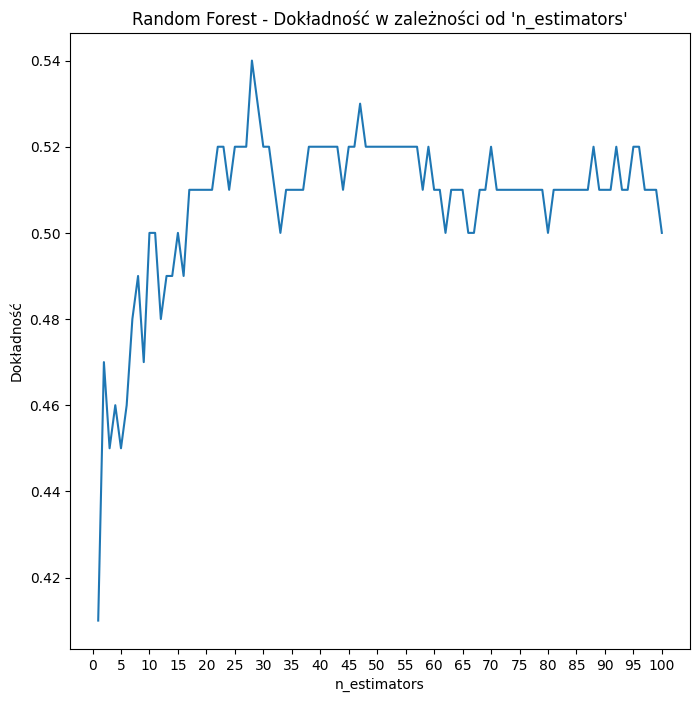

In [18]:
plot_scores_rf = []

for n_estimators in range(1, 101):
    clf_rf = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=10, random_state=1)
    clf_rf.fit(X_train,y_train)
    test_preds = clf_rf.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_rf.append(score)
 
plt.figure(figsize = (8, 8))
plt.plot(range(1, 101), plot_scores_rf)
plt.title("Random Forest - Dokładność w zależności od 'n_estimators'")
plt.xlabel('n_estimators')
plt.ylabel('Dokładność')
plt.xticks(range(0, 101, 5))

best_accuracy = max(plot_scores_rf)
best_n = plot_scores_rf.index(best_accuracy)+1
print(f'Best accuracy: {best_accuracy}; n={best_n}')

In [104]:
rf = RandomForestClassifier(n_estimators=28, min_samples_split=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=28, random_state=1)

In [105]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.49      0.81      0.61       144
                Remis       0.37      0.12      0.18        83
     Zwycięstwo gości       0.59      0.44      0.50       153

             accuracy                           0.51       380
            macro avg       0.48      0.46      0.43       380
         weighted avg       0.50      0.51      0.47       380



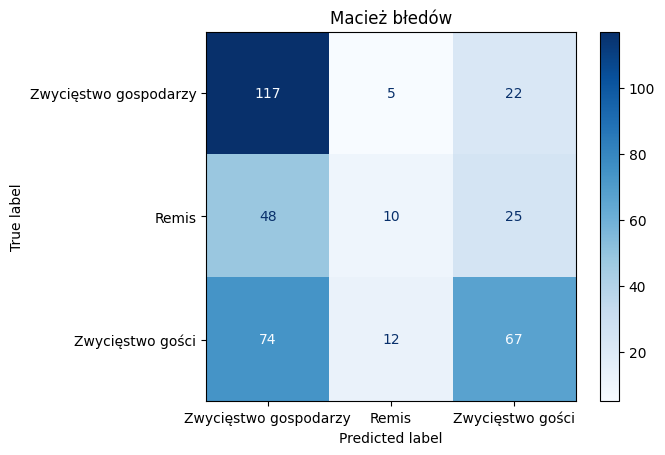

In [106]:
rf_test_preds = rf.predict(X_test)

report = classification_report(y_test, rf_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, rf_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macież błedów')
plt.show()

In [22]:
rf_train_preds = rf.predict(X_train)

rf_train_accuracy = accuracy_score(y_train, rf_train_preds)
print(f'Random Forest Train Accuracy: {rf_train_accuracy:.2f}')

Random Forest Train Accuracy: 0.87


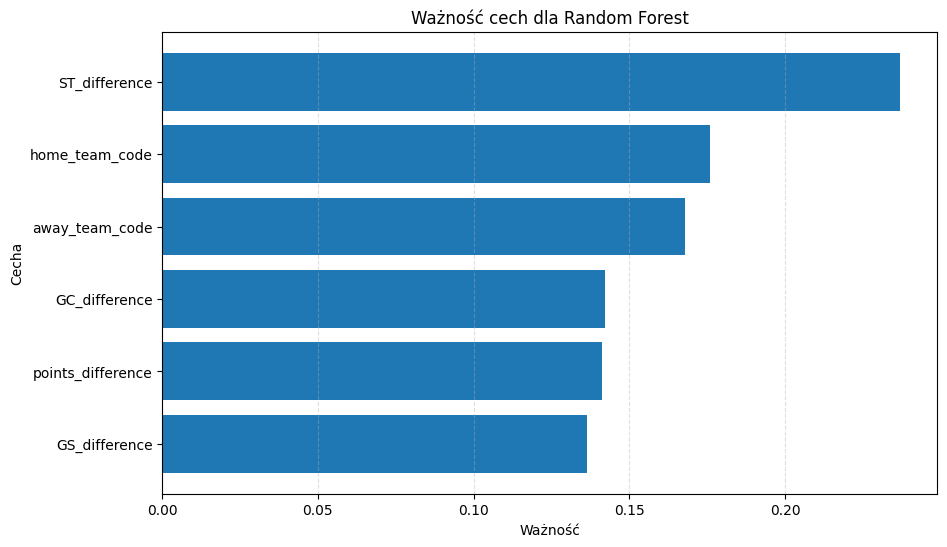

In [23]:
feature_importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Ważność')
plt.ylabel('Cecha')
plt.title('Ważność cech dla Random Forest')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.xlim(0)
plt.show()

***
Próba zbalansowania zbioru treningowego

In [24]:
class_counts = train['FTR'].value_counts()

print(class_counts)

FTR
H    1014
A     658
D     583
Name: count, dtype: int64


In [25]:
from sklearn.utils import resample

In [26]:
class_counts = train['FTR'].value_counts()
minority_class = class_counts.idxmin()

balanced_train = pd.concat([
    resample(train[train['FTR'] == cls], 
             replace=True,
             n_samples=class_counts[minority_class],
             random_state=42)
    for cls in class_counts.index
])

print(balanced_train['FTR'].value_counts())


FTR
H    583
A    583
D    583
Name: count, dtype: int64


In [27]:
predictors = [
    'home_team_code', 
    'away_team_code',
    'points_difference',
    'GS_difference',
    'GC_difference',
    'ST_difference',
]

X_train = balanced_train[predictors]
y_train = balanced_train['target']

X_test = test[predictors]
y_test = test['target']

In [28]:
rf2 = RandomForestClassifier(n_estimators=28, min_samples_split=10, random_state=1)
rf2.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=28, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.59      0.50      0.54       187
                Remis       0.27      0.31      0.29        84
     Zwycięstwo gości       0.44      0.50      0.47       109

             accuracy                           0.46       380
            macro avg       0.43      0.44      0.43       380
         weighted avg       0.48      0.46      0.47       380



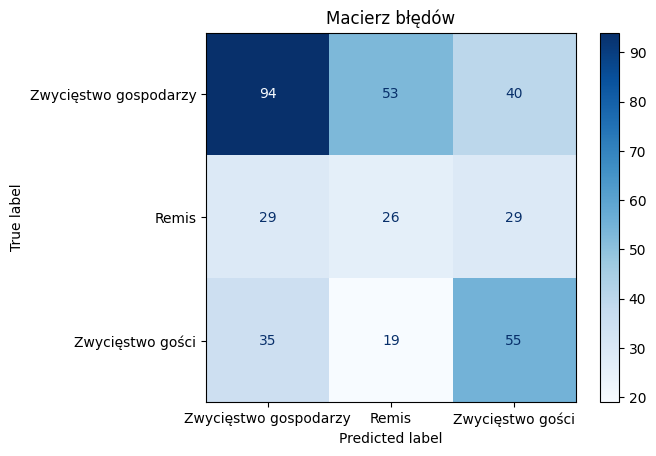

In [29]:
rf2_test_preds = rf2.predict(X_test)

report = classification_report(y_test, rf2_test_preds,
                              target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, rf2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów')
plt.show()

***
Próba zastosowania wyższych wag dla 2 ostatnich sezonów

In [30]:
predictors = [
    'home_team_code', 
    'away_team_code',
    'points_difference',
    'GS_difference',
    'GC_difference',
    'ST_difference',
]

X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

In [31]:
train_weights = train['season'].apply(lambda x: 2 if x in [2015, 2014] else 1)
train_weights

3800    1
3802    1
3803    1
3804    1
3805    1
       ..
6075    2
6076    2
6077    2
6078    2
6079    2
Name: season, Length: 2255, dtype: int64

In [32]:
rf3 = RandomForestClassifier(n_estimators=28, min_samples_split=10, random_state=1)
rf3.fit(X_train, y_train, sample_weight=train_weights)

RandomForestClassifier(min_samples_split=10, n_estimators=28, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.61      0.71      0.66       187
                Remis       0.29      0.14      0.19        84
     Zwycięstwo gości       0.43      0.49      0.46       109

             accuracy                           0.52       380
            macro avg       0.44      0.44      0.43       380
         weighted avg       0.49      0.52      0.50       380



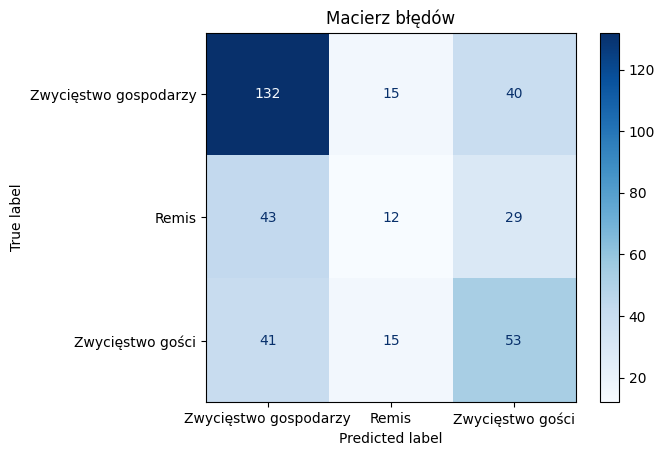

In [33]:
rf3_test_preds = rf3.predict(X_test)

report = classification_report(y_test, rf3_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, rf3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów')
plt.show()

In [34]:
from sklearn.neighbors import KNeighborsClassifier

Best accuracy: 0.56; n=20


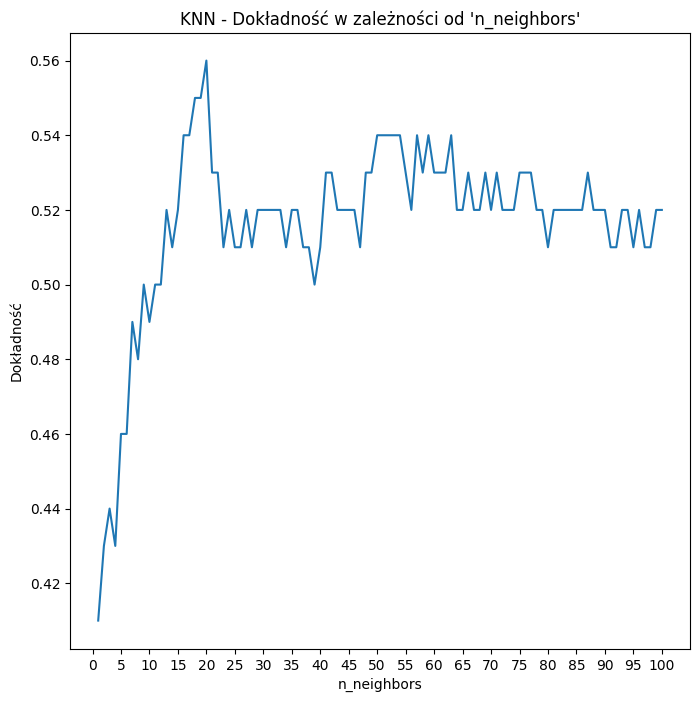

In [35]:
plot_scores_knn = []

for n_neighbors in range(1, 101):
    clf_knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf_knn.fit(X_train,y_train)
    test_preds = clf_knn.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_knn.append(score)
 
plt.figure(figsize = (8, 8))
plt.plot(range(1, 101),plot_scores_knn)
plt.title("KNN - Dokładność w zależności od 'n_neighbors'")
plt.xlabel('n_neighbors')
plt.ylabel('Dokładność')
plt.xticks(range(0, 101, 5))

best_accuracy = max(plot_scores_knn)
best_n = plot_scores_knn.index(best_accuracy)+1
print(f'Best accuracy: {best_accuracy}; n={best_n}')

In [36]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.60      0.77      0.67       187
                Remis       0.37      0.23      0.28        84
     Zwycięstwo gości       0.56      0.45      0.50       109

             accuracy                           0.56       380
            macro avg       0.51      0.48      0.48       380
         weighted avg       0.54      0.56      0.54       380



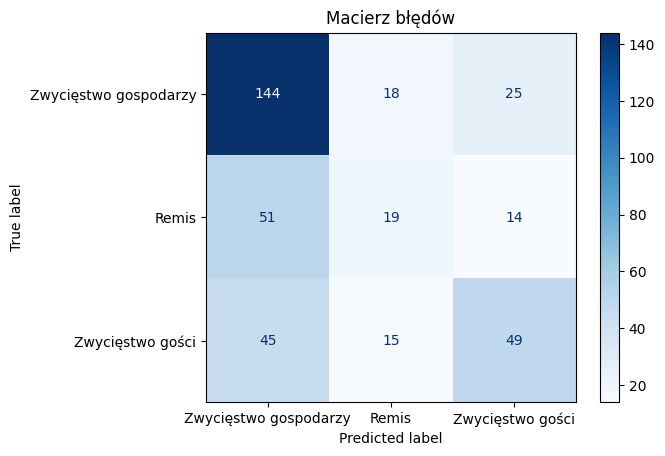

In [37]:
knn_test_preds = knn.predict(X_test)

report = classification_report(y_test, knn_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości']
)

print(report)

conf_matrix = confusion_matrix(y_test, knn_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów')
plt.show()

In [38]:
knn_train_preds = knn.predict(X_train)

knn_train_accuracy = accuracy_score(y_train, knn_train_preds)
print(f'KNN Train accuracy: {knn_train_accuracy:.2f}')

KNN Train accuracy: 0.53


***
Próba wykorzystania zbalansowanego zbioru treningowego

In [39]:
predictors = [
    'home_team_code', 
    'away_team_code',
    'points_difference',
    'GS_difference',
    'GC_difference',
    'ST_difference',
]

X_train = balanced_train[predictors]
y_train = balanced_train['target']

X_test = test[predictors]
y_test = test['target']

In [40]:
knn2 = KNeighborsClassifier(n_neighbors=20)
knn2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.54      0.39      0.45       187
                Remis       0.23      0.35      0.28        84
     Zwycięstwo gości       0.47      0.51      0.49       109

             accuracy                           0.42       380
            macro avg       0.41      0.42      0.41       380
         weighted avg       0.45      0.42      0.43       380



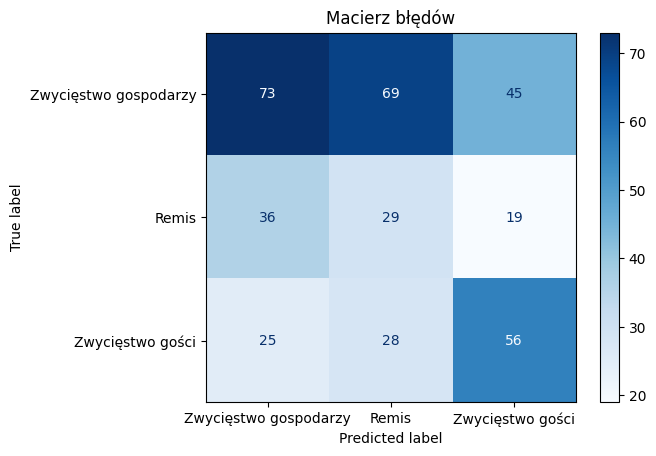

In [41]:
knn2_test_preds = knn2.predict(X_test)

report = classification_report(y_test, knn2_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, knn2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów')
plt.show()

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
predictors = [
    'home_team_code', 
    'away_team_code',
    'points_difference',
    'GS_difference',
    'GC_difference',
    'ST_difference',
]

X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

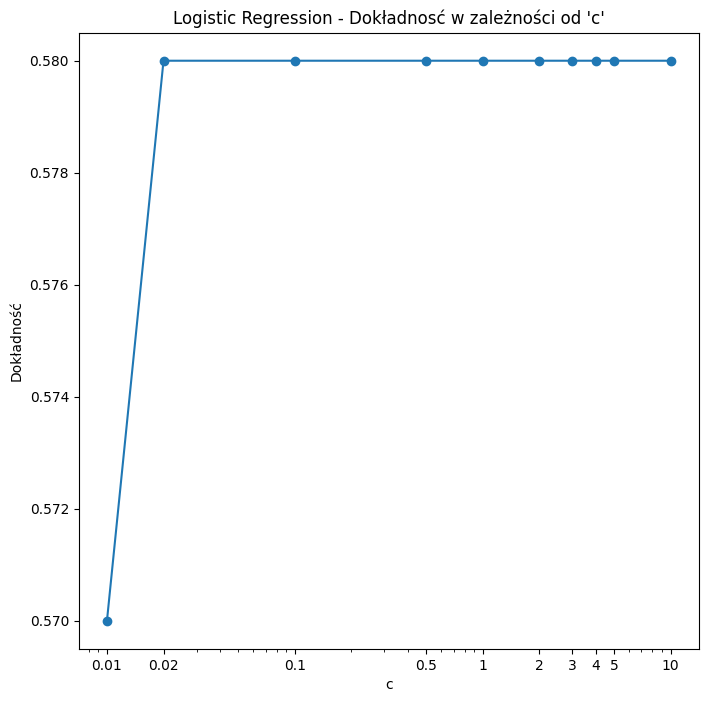

Best accuracy: 0.58; c=0.02


In [44]:
plot_scores_lr = []

cs = [0.01, 0.02, 0.1, 0.5, 1, 2, 3, 4, 5, 10]

for c in cs:
    lr = LogisticRegression(C=c, solver='lbfgs', multi_class='multinomial', max_iter=1000, random_state=1)
    lr.fit(X_train, y_train)
    test_preds = lr.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_lr.append(score)
 
plt.figure(figsize=(8, 8))
plt.plot(cs, plot_scores_lr, marker='o')
plt.title("Logistic Regression - Dokładnosć w zależności od 'c'")
plt.xlabel("c")
plt.ylabel('Dokładność')
plt.xscale('log')
plt.xticks(cs, cs)
plt.show()

best_accuracy = max(plot_scores_lr)
best_c = cs[plot_scores_lr.index(best_accuracy)]
print(f'Best accuracy: {best_accuracy}; c={best_c}')

In [45]:
lr = LogisticRegression(C=0.02, solver='lbfgs', multi_class='multinomial', max_iter=1000, random_state=1)
lr.fit(X_train, y_train)

LogisticRegression(C=0.02, max_iter=1000, multi_class='multinomial',
                   random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.59      0.87      0.70       187
                Remis       0.00      0.00      0.00        84
     Zwycięstwo gości       0.55      0.51      0.53       109

             accuracy                           0.58       380
            macro avg       0.38      0.46      0.41       380
         weighted avg       0.45      0.58      0.50       380



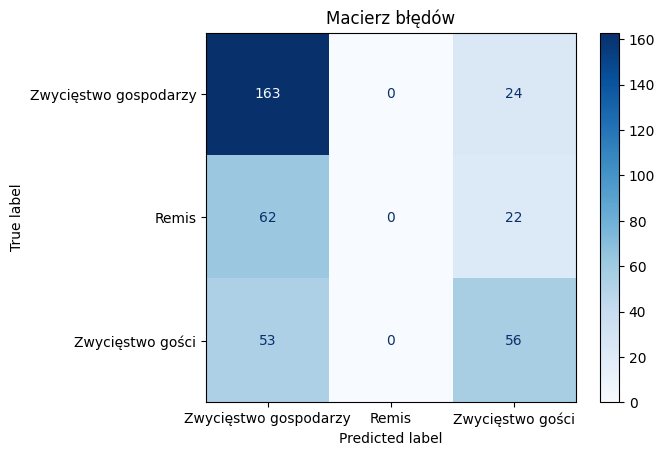

In [46]:
lr_test_preds = lr.predict(X_test)

report = classification_report(y_test, lr_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, lr_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów')
plt.show()

In [47]:
lr_train_preds = lr.predict(X_train)

lr_train_accuracy = accuracy_score(y_train, lr_train_preds)
print(f'Logistic Regression Train accuracy: {lr_train_accuracy:.2f}')

Logistic Regression Train accuracy: 0.50


***
Próba wykorzystania zbalansowanego zbioru treningowego

In [48]:
predictors = [
    'home_team_code', 
    'away_team_code',
    'points_difference',
    'GS_difference',
    'GC_difference',
    'ST_difference',
]

X_train = balanced_train[predictors]
y_train = balanced_train['target']

X_test = test[predictors]
y_test = test['target']

In [49]:
lr2 = LogisticRegression(C=0.02, solver='lbfgs', multi_class='multinomial', max_iter=1000, random_state=1)
lr2.fit(X_train, y_train)

LogisticRegression(C=0.02, max_iter=1000, multi_class='multinomial',
                   random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.59      0.87      0.70       187
                Remis       0.00      0.00      0.00        84
     Zwycięstwo gości       0.55      0.51      0.53       109

             accuracy                           0.58       380
            macro avg       0.38      0.46      0.41       380
         weighted avg       0.45      0.58      0.50       380



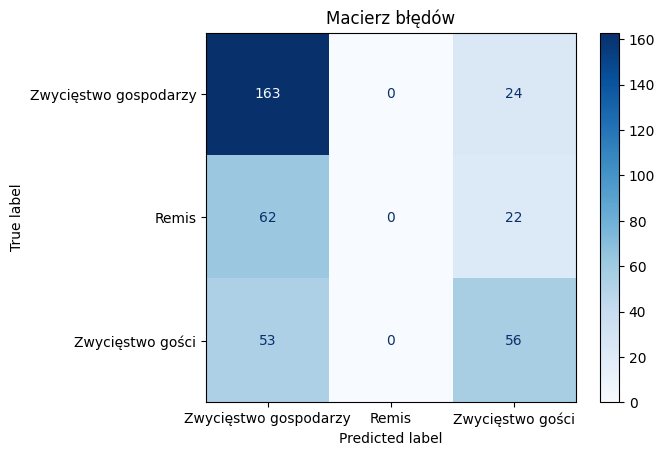

In [50]:
lr2_test_preds = lr.predict(X_test)

report = classification_report(y_test, lr2_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, lr2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów')
plt.show()

In [51]:
from xgboost import XGBClassifier

In [52]:
predictors = [
    'home_team_code', 
    'away_team_code',
    'points_difference',
    'GS_difference',
    'GC_difference',
    'ST_difference',
]

X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

Best accuracy: 0.53; n=8


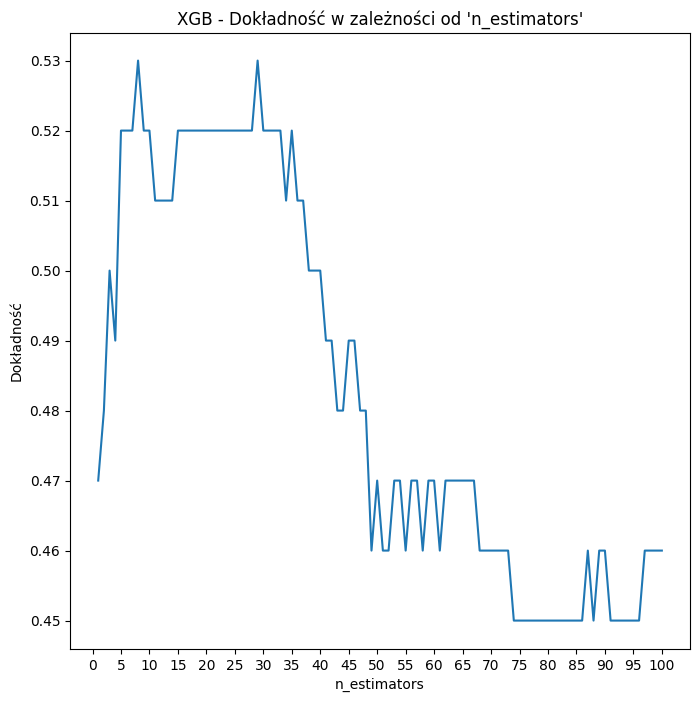

In [53]:
plot_scores_xgb = []

for n in range(1, 101):
    xgb = XGBClassifier(n_estimators=n, min_samples_split=10, random_state=1)
    xgb.fit(X_train,y_train)
    test_preds = xgb.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_xgb.append(score)
 
plt.figure(figsize = (8, 8))
plt.plot(range(1, 101), plot_scores_xgb)
plt.title("XGB - Dokładność w zależności od 'n_estimators'")
plt.xlabel('n_estimators')
plt.ylabel('Dokładność')
plt.xticks(range(0, 101, 5))

best_accuracy = max(plot_scores_xgb)
best_n = plot_scores_xgb.index(best_accuracy)+1
print(f'Best accuracy: {best_accuracy}; n={best_n}')

In [54]:
xgb = XGBClassifier(n_estimators=8, min_samples_split=10, random_state=1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_samples_split=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=8,
              n_jobs=None, num_parallel_tree=None, ...)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.58      0.76      0.66       187
                Remis       0.18      0.05      0.08        84
     Zwycięstwo gości       0.49      0.50      0.50       109

             accuracy                           0.53       380
            macro avg       0.42      0.44      0.41       380
         weighted avg       0.47      0.53      0.48       380



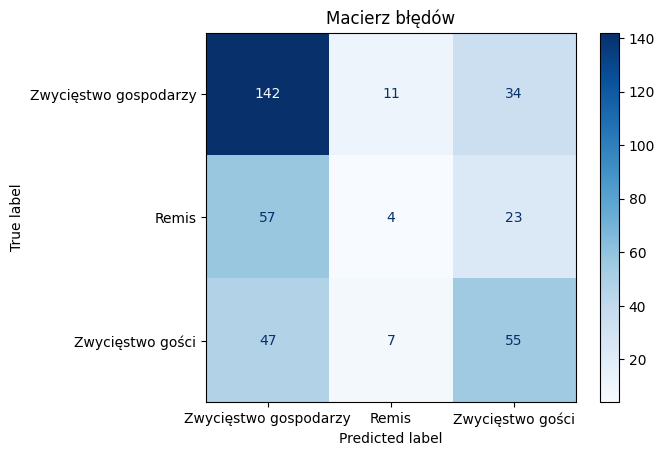

In [55]:
xgb_test_preds = xgb.predict(X_test)

report = classification_report(y_test, xgb_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, xgb_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów')
plt.show()

In [56]:
xgb_train_preds = xgb.predict(X_train)

xgb_train_accuracy = accuracy_score(y_train, xgb_train_preds)
print(f'XGB Train accuracy: {xgb_train_accuracy:.2f}')

XGB Train accuracy: 0.65


***
Proba zastosowania wag

In [57]:
train_weights = train['season'].apply(lambda x: 2 if x in [2015, 2014] else 1)
train_weights

3800    1
3802    1
3803    1
3804    1
3805    1
       ..
6075    2
6076    2
6077    2
6078    2
6079    2
Name: season, Length: 2255, dtype: int64

In [58]:
xgb2 = XGBClassifier(n_estimators=8, min_samples_split=10, random_state=1)
xgb2.fit(X_train, y_train, sample_weight=train_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_samples_split=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=8,
              n_jobs=None, num_parallel_tree=None, ...)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.59      0.73      0.65       187
                Remis       0.41      0.08      0.14        84
     Zwycięstwo gości       0.43      0.50      0.46       109

             accuracy                           0.52       380
            macro avg       0.47      0.44      0.42       380
         weighted avg       0.50      0.52      0.48       380



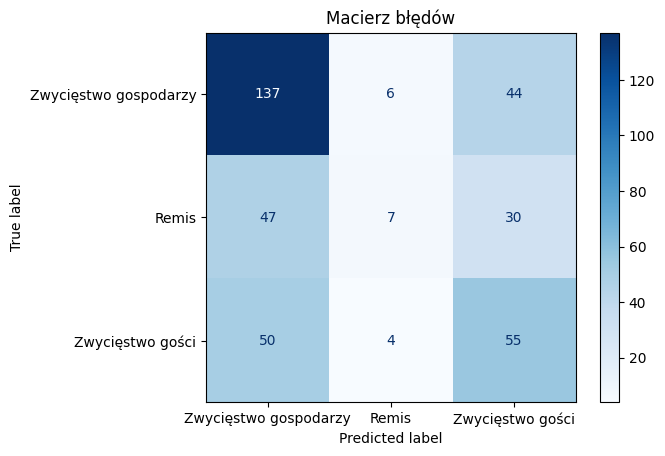

In [59]:
xgb2_test_preds = xgb2.predict(X_test)

report = classification_report(y_test, xgb2_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, xgb2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów')
plt.show()

***
Próba zastosowania zbalansowanego zbioru treningowego

In [60]:
predictors = [
    'home_team_code', 
    'away_team_code',
    'points_difference',
    'GS_difference',
    'GC_difference',
    'ST_difference',
]

X_train = balanced_train[predictors]
y_train = balanced_train['target']

X_test = test[predictors]
y_test = test['target']

In [61]:
xgb3 = XGBClassifier(n_estimators=8, min_samples_split=10, random_state=1)
xgb3.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_samples_split=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=8,
              n_jobs=None, num_parallel_tree=None, ...)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.59      0.73      0.65       187
                Remis       0.41      0.08      0.14        84
     Zwycięstwo gości       0.43      0.50      0.46       109

             accuracy                           0.52       380
            macro avg       0.47      0.44      0.42       380
         weighted avg       0.50      0.52      0.48       380



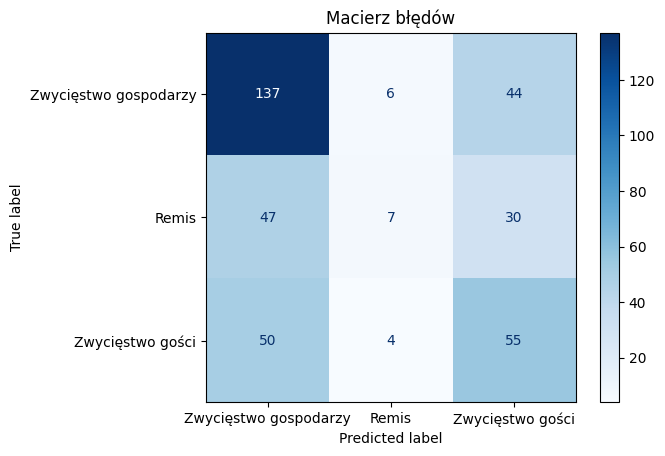

In [62]:
xgb3_test_preds = xgb2.predict(X_test)

report = classification_report(y_test, xgb3_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, xgb3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów')
plt.show()

In [63]:
from sklearn.svm import SVC

In [64]:
predictors = [
    'home_team_code', 
    'away_team_code',
    'points_difference',
    'GS_difference',
    'GC_difference',
    'ST_difference',
]

X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

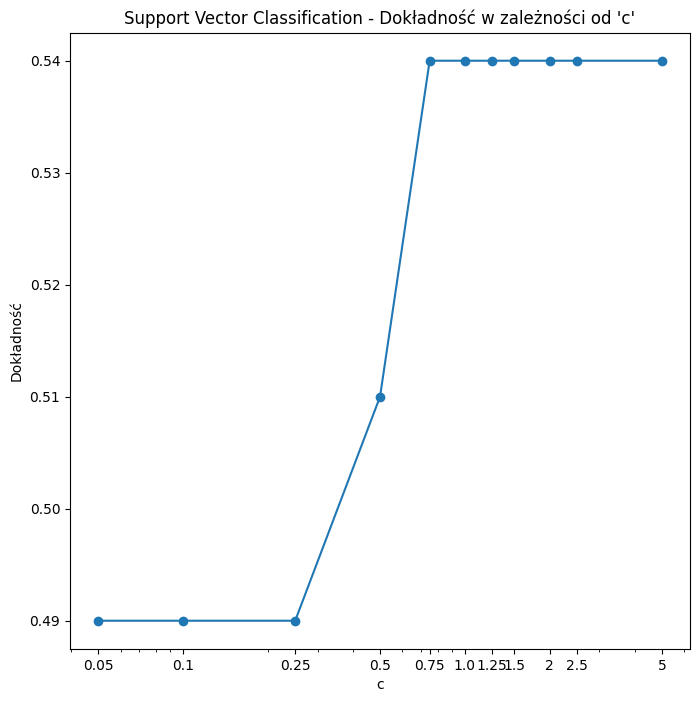

Best accuracy: 0.54; c=0.75


In [65]:
plot_scores_svc = []

cs = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2, 2.5, 5]

for c in cs:
    svc = SVC(kernel='rbf', C=c, random_state=1)
    svc.fit(X_train, y_train)
    test_preds = svc.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_svc.append(score)
 
plt.figure(figsize=(8, 8))
plt.plot(cs, plot_scores_svc, marker='o')
plt.title("Support Vector Classification - Dokładność w zależności od 'c'")
plt.xlabel("c")
plt.ylabel("Dokładność")
plt.xscale('log') 
plt.xticks(cs, cs)
plt.show()

best_accuracy = max(plot_scores_svc)
best_c = cs[plot_scores_svc.index(best_accuracy)]
print(f'Best accuracy: {best_accuracy}; c={best_c}')

In [66]:
svc = SVC(kernel='rbf', C=1, random_state=1)
svc.fit(X_train, y_train)

SVC(C=1, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.54      0.89      0.67       187
                Remis       0.00      0.00      0.00        84
     Zwycięstwo gości       0.55      0.37      0.44       109

             accuracy                           0.54       380
            macro avg       0.36      0.42      0.37       380
         weighted avg       0.42      0.54      0.46       380



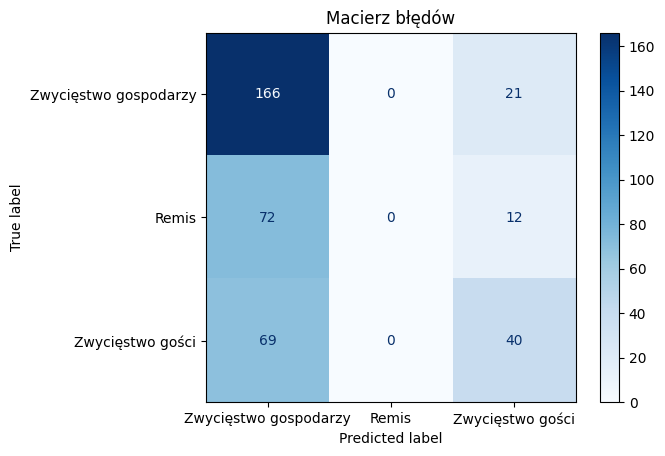

In [67]:
svc_test_preds = svc.predict(X_test)

report = classification_report(y_test, svc_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, svc_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów')
plt.show()

In [68]:
svc_train_preds = svc.predict(X_train)

svc_train_accuracy = accuracy_score(y_train, svc_train_preds)
print(f'SVM Train accuracy: {svc_train_accuracy:.2f}')

SVM Train accuracy: 0.50


***
Proba zastosowania zbalansowangeo zbioru treningowego

In [69]:
predictors = [
    'home_team_code', 
    'away_team_code',
    'points_difference',
    'GS_difference',
    'GC_difference',
    'ST_difference',
]

X_train = balanced_train[predictors]
y_train = balanced_train['target']

X_test = test[predictors]
y_test = test['target']

In [70]:
svc2 = SVC(kernel='rbf', C=1, random_state=1)
svc2.fit(X_train, y_train)

SVC(C=1, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.58      0.51      0.55       187
                Remis       0.15      0.13      0.14        84
     Zwycięstwo gości       0.46      0.61      0.53       109

             accuracy                           0.46       380
            macro avg       0.40      0.42      0.40       380
         weighted avg       0.45      0.46      0.45       380



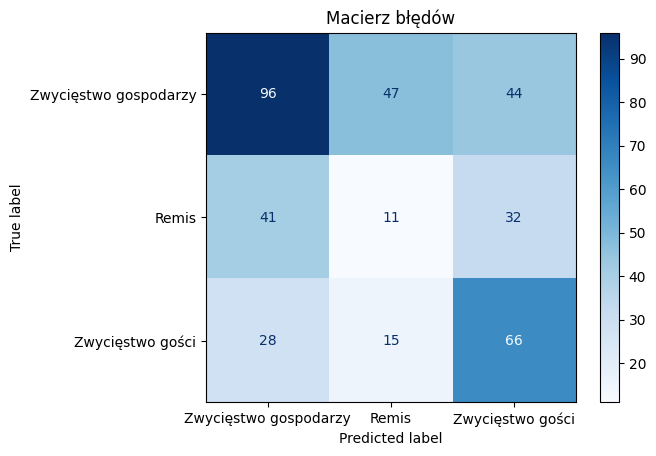

In [71]:
svc2_test_preds = svc2.predict(X_test)

report = classification_report(y_test, svc2_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, svc2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów')
plt.show()

In [72]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [73]:
predictors = [
    'home_team_code', 
    'away_team_code',
    'points_difference',
    'GS_difference',
    'GC_difference',
    'ST_difference',
]

X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

In [74]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [75]:
nn = Sequential()
nn.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn.add(Dense(128, activation='relu')) 
nn.add(Dense(64, activation='relu'))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(3, activation='softmax'))

In [76]:
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [77]:
nn.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100


57/57 [==============================] - 1s 5ms/step - loss: 1.0334 - accuracy: 0.4906 - val_loss: 1.0392 - val_accuracy: 0.4878
Epoch 2/100
57/57 [==============================] - 0s 2ms/step - loss: 1.0117 - accuracy: 0.5094 - val_loss: 1.0401 - val_accuracy: 0.4723
Epoch 3/100
57/57 [==============================] - 0s 2ms/step - loss: 1.0064 - accuracy: 0.5067 - val_loss: 1.0395 - val_accuracy: 0.4767
Epoch 4/100
57/57 [==============================] - 0s 2ms/step - loss: 1.0002 - accuracy: 0.5100 - val_loss: 1.0425 - val_accuracy: 0.4701
Epoch 5/100
57/57 [==============================] - 0s 2ms/step - loss: 0.9969 - accuracy: 0.5133 - val_loss: 1.0502 - val_accuracy: 0.4701
Epoch 6/100
57/57 [==============================] - 0s 2ms/step - loss: 0.9961 - accuracy: 0.5072 - val_loss: 1.0517 - val_accuracy: 0.4678
Epoch 7/100
57/57 [==============================] - 0s 2ms/step - loss: 0.9882 - accuracy: 0.5161 - val_loss: 1.0423 - val_accuracy: 0.4856
Epoch 8/100

57/57 [==============================] - 0s 2ms/step - loss: 0.5468 - accuracy: 0.7627 - val_loss: 1.6166 - val_accuracy: 0.3814
Epoch 56/100
57/57 [==============================] - 0s 2ms/step - loss: 0.5289 - accuracy: 0.7744 - val_loss: 1.6038 - val_accuracy: 0.3747
Epoch 57/100
57/57 [==============================] - 0s 2ms/step - loss: 0.5126 - accuracy: 0.7794 - val_loss: 1.6477 - val_accuracy: 0.3836
Epoch 58/100
57/57 [==============================] - 0s 2ms/step - loss: 0.5079 - accuracy: 0.7838 - val_loss: 1.6884 - val_accuracy: 0.3858
Epoch 59/100
57/57 [==============================] - 0s 2ms/step - loss: 0.4858 - accuracy: 0.8088 - val_loss: 1.6762 - val_accuracy: 0.3947
Epoch 60/100
57/57 [==============================] - 0s 2ms/step - loss: 0.4941 - accuracy: 0.7871 - val_loss: 1.6380 - val_accuracy: 0.3769
Epoch 61/100
57/57 [==============================] - 0s 2ms/step - loss: 0.4857 - accuracy: 0.8038 - val_loss: 1.7076 - val_accuracy: 0.3769
Epoch 62/100
57/57 

In [78]:
import numpy as np

nn_test_preds = nn.predict(X_test)
nn_test_preds = np.argmax(nn_test_preds, axis=1)

12/12 [==============================] - 0s 1ms/step


                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.55      0.57      0.56       187
                Remis       0.28      0.26      0.27        84
     Zwycięstwo gości       0.37      0.35      0.36       109

             accuracy                           0.44       380
            macro avg       0.40      0.39      0.39       380
         weighted avg       0.43      0.44      0.44       380



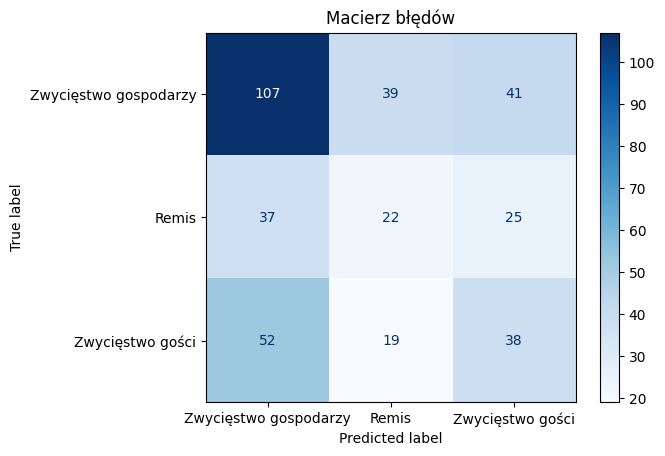

In [79]:
nn_report = classification_report(y_test, nn_test_preds, 
                                  target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(nn_report)

nn_conf_matrix = confusion_matrix(y_test, nn_test_preds, labels=[0, 1, 2])
nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_conf_matrix, 
                                 display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

nn_disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów')
plt.show()

***
Próba zastosowania zbalansowanego zbioru treningowego

In [80]:
predictors = [
    'home_team_code', 
    'away_team_code',
    'points_difference',
    'GS_difference',
    'GC_difference',
    'ST_difference',
]

X_train = balanced_train[predictors]
y_train = balanced_train['target']

X_test = test[predictors]
y_test = test['target']

In [81]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [82]:
nn.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
44/44 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.7963 - val_loss: 0.9782 - val_accuracy: 0.7000
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 0.4890 - accuracy: 0.8263 - val_loss: 0.8288 - val_accuracy: 0.7600
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 0.3701 - accuracy: 0.8728 - val_loss: 0.7214 - val_accuracy: 0.7829
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 0.3075 - accuracy: 0.8949 - val_loss: 0.8381 - val_accuracy: 0.7371
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 0.2740 - accuracy: 0.9064 - val_loss: 0.9228 - val_accuracy: 0.7171
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 0.2130 - accuracy: 0.9378 - val_loss: 0.9674 - val_accuracy: 0.7143
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 0.1852 - accuracy: 0.9543 - val_loss: 0.9065 - val_accuracy: 0.7057
Epoch 8/100
4

Epoch 59/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 1.7697 - val_accuracy: 0.6714
Epoch 60/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 1.7650 - val_accuracy: 0.6714
Epoch 61/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 1.6444 - val_accuracy: 0.6771
Epoch 62/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.7761 - val_accuracy: 0.6743
Epoch 63/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.7238 - val_accuracy: 0.6743
Epoch 64/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.8561 - val_accuracy: 0.6600
Epoch 65/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.8141 - val_accuracy: 0.6657
Epoch 

In [83]:
nn2_test_preds = nn.predict(X_test)
nn2_test_preds = np.argmax(nn2_test_preds, axis=1)

12/12 [==============================] - 0s 1ms/step


                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.55      0.52      0.54       187
                Remis       0.29      0.20      0.24        84
     Zwycięstwo gości       0.35      0.46      0.40       109

             accuracy                           0.43       380
            macro avg       0.40      0.40      0.39       380
         weighted avg       0.43      0.43      0.43       380



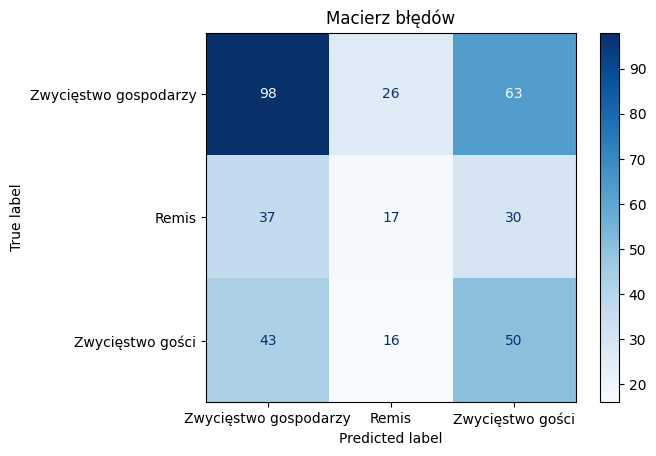

In [84]:
nn_report = classification_report(y_test, nn2_test_preds, 
                                  target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(nn_report)

nn_conf_matrix = confusion_matrix(y_test, nn2_test_preds, labels=[0, 1, 2])
nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_conf_matrix, 
                                 display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

nn_disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów')
plt.show()

***
Stacking

In [85]:
from sklearn.ensemble import StackingClassifier

In [86]:
predictors = [
    'home_team_code', 
    'away_team_code',
    'points_difference',
    'GS_difference',
    'GC_difference',
    'ST_difference',
]

X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

In [87]:
estimators = [('xgb', xgb), ('knn', knn)]

stacked = StackingClassifier(
    estimators=estimators,
    final_estimator=rf
)
                                   
stacked.fit(X_train, y_train)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              min_samples_split=10, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=8, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('knn', KNeighborsClassifier(n_neighbors=20))],
                   final_estimator=RandomForestClassifier(min_samples_split=10,
                                                          n_estimators=28,
                                                          random_state=1))

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.60      0.67      0.63       187
                Remis       0.33      0.24      0.28        84
     Zwycięstwo gości       0.47      0.47      0.47       109

             accuracy                           0.52       380
            macro avg       0.47      0.46      0.46       380
         weighted avg       0.50      0.52      0.51       380



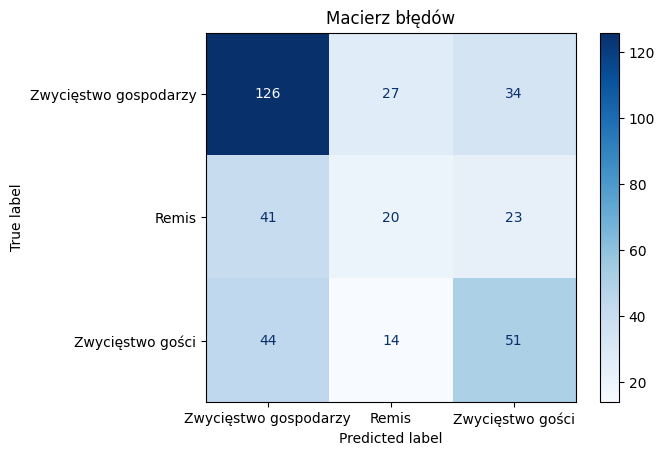

In [88]:
test_accuracy = stacked.score(X_test, y_test)

stacked_test_preds = stacked.predict(X_test)

report = classification_report(y_test, stacked_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, stacked_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów')
plt.show()

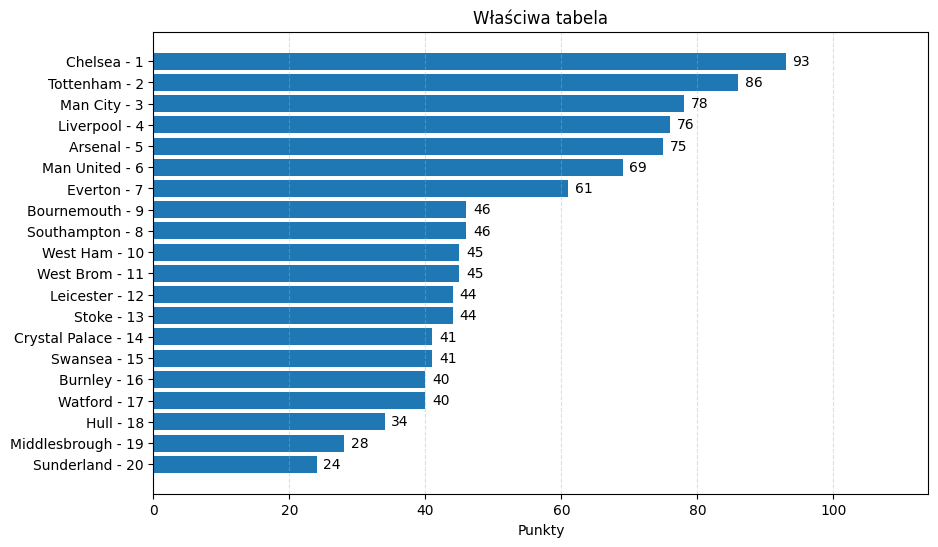

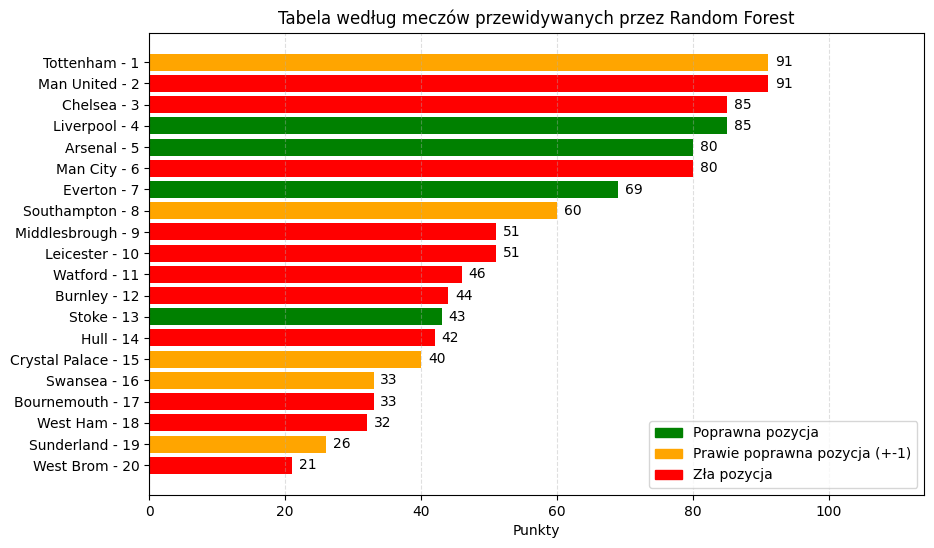

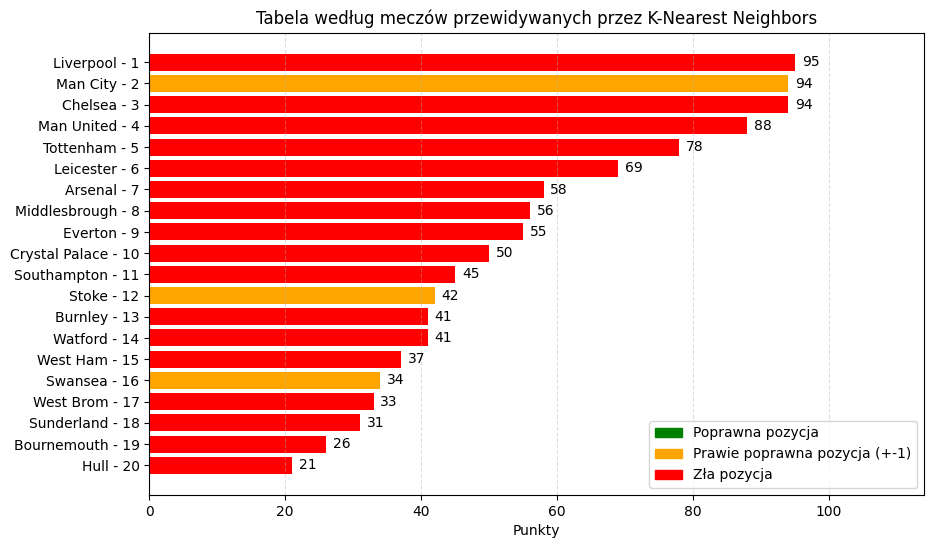

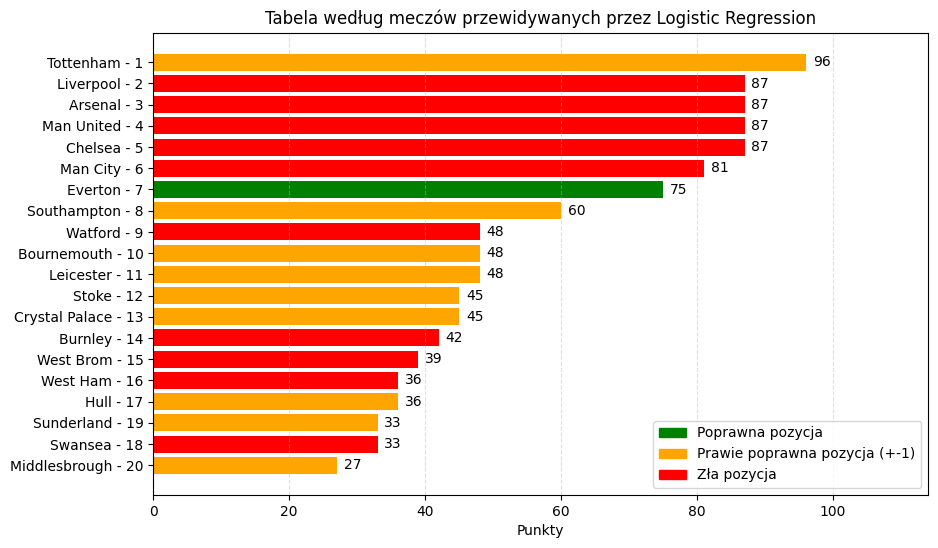

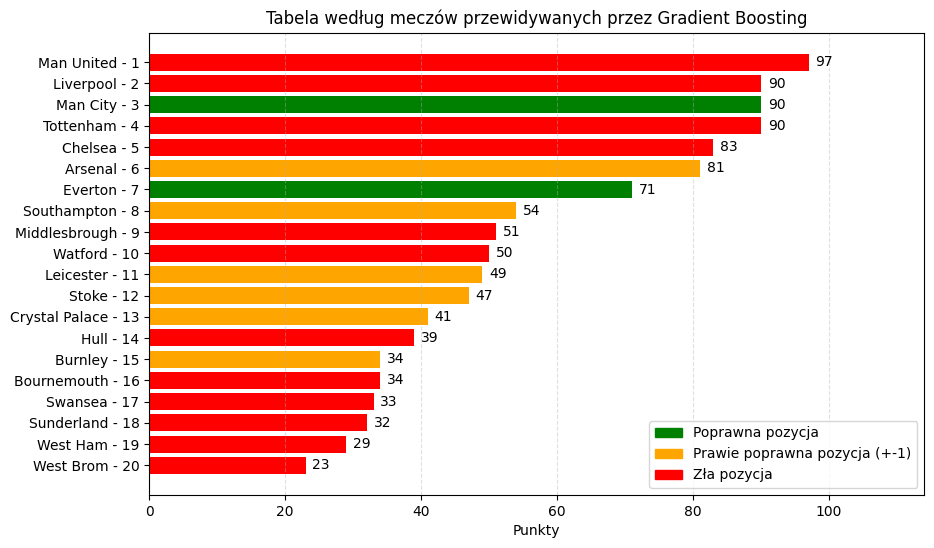

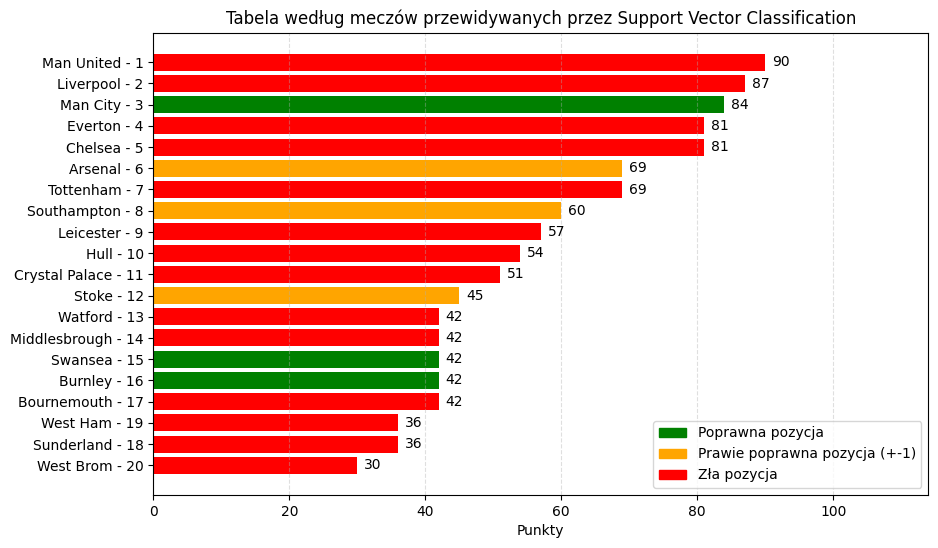

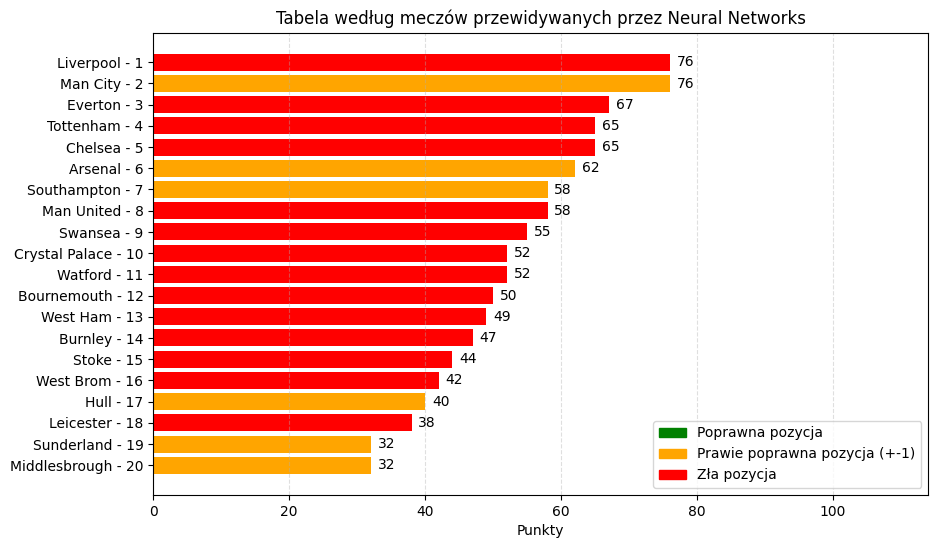

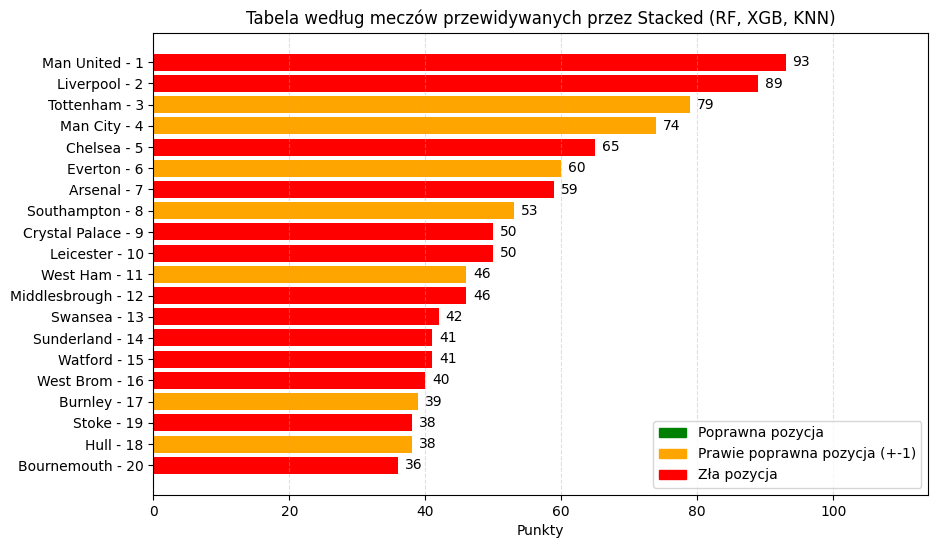

In [89]:
from collections import defaultdict
import matplotlib.patches as mpatches

results = test[['home_team', 'away_team', 'FTR']].copy()

algorithms = {
    'Random Forest': rf_test_preds, 
    'K-Nearest Neighbors': knn_test_preds,
    'Logistic Regression' : lr_test_preds,
    'Gradient Boosting': xgb_test_preds,
    'Support Vector Classification': svc_test_preds,
    'Neural Networks' : nn_test_preds,
    'Stacked (RF, XGB, KNN)': stacked_test_preds
}

actual_points_dict = defaultdict(int)
for index, row in results.iterrows():
    if row['FTR'] == 'H':
        actual_points_dict[row['home_team']] += 3
    elif row['FTR'] == 'D':
        actual_points_dict[row['home_team']] += 1
        actual_points_dict[row['away_team']] += 1
    elif row['FTR'] == 'A':
        actual_points_dict[row['away_team']] += 3

actual_points_table = pd.DataFrame(list(actual_points_dict.items()), columns=['team', 'actual_points'])
actual_points_table = actual_points_table.sort_values(by='actual_points', ascending=False).reset_index(drop=True)
actual_points_table.index += 1

actual_points_table = actual_points_table.sort_values(by='actual_points', ascending=True)

plt.figure(figsize=(10, 6))
bars = plt.barh(actual_points_table['team'].str.cat(actual_points_table.index.astype(str), sep=' - '), actual_points_table['actual_points'])
plt.title('Właściwa tabela')
plt.xlabel('Punkty')
plt.xlim(0, 114)
plt.grid(axis='x', linestyle='--', alpha=0.4)

for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, str(int(bar.get_width())), color='black', va='center')

plt.show()

for algo_name, algo_preds in algorithms.items():
    points_dicts = {f'{algo_name}_predicted': defaultdict(int)}

    results[f'result_{algo_name}'] = np.vectorize({0: 'H', 1: 'D', 2: 'A'}.get)(algo_preds)

    for index, row in results.iterrows():
        if row[f'result_{algo_name}'] == 'H':
            points_dicts[f'{algo_name}_predicted'][row['home_team']] += 3
        elif row[f'result_{algo_name}'] == 'D':
            points_dicts[f'{algo_name}_predicted'][row['home_team']] += 1
            points_dicts[f'{algo_name}_predicted'][row['away_team']] += 1
        elif row[f'result_{algo_name}'] == 'A':
            points_dicts[f'{algo_name}_predicted'][row['away_team']] += 3

    algo_points_table = pd.DataFrame(list(points_dicts[f'{algo_name}_predicted'].items()), columns=['team', 'predicted_points'])
    algo_points_table = algo_points_table.sort_values(by='predicted_points', ascending=False).reset_index(drop=True)
    algo_points_table.index += 1
    
    algo_points_table = algo_points_table.sort_values(by='predicted_points', ascending=True)
    
    plt.figure(figsize=(10, 6))
    colors = [
        'green' if i == j else 
        'orange' if abs(
            actual_points_table.index[actual_points_table['team'] == j][0] - 
            algo_points_table.index[algo_points_table['team'] == j][0]
        ) <= 1 else 'red'
        for i, j in zip(actual_points_table.team, algo_points_table.team)
    ]
    bars = plt.barh(algo_points_table['team'].str.cat(algo_points_table.index.astype(str), sep=' - '), 
                    algo_points_table['predicted_points'], 
                    color=colors)
    
    plt.title(f'Tabela według meczów przewidywanych przez {algo_name}')
    plt.xlabel('Punkty')
    plt.xlim(0, 114)
    plt.grid(axis='x', linestyle='--', alpha=0.4)

    for bar in bars:
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, str(int(bar.get_width())), color='black', va='center')

    
    green_patch = mpatches.Patch(color='green', label='Poprawna pozycja')
    orange_patch = mpatches.Patch(color='orange', label='Prawie poprawna pozycja (+-1)')
    red_patch = mpatches.Patch(color='red', label='Zła pozycja')

    plt.legend(handles=[green_patch, orange_patch, red_patch])
    plt.show()


In [90]:
training_sets = []

train1 = df[(df['season'] == 2010)]
training_sets.append(train1)

train2 = df[(df['season'] >= 2010) & (df['season'] <= 2011)]
training_sets.append(train2)

train3 = df[(df['season'] >= 2010) & (df['season'] <= 2012)]
training_sets.append(train3)

train4 = df[(df['season'] >= 2010) & (df['season'] <= 2013)]
training_sets.append(train4)

train5 = df[(df['season'] >= 2010) & (df['season'] <= 2014)]
training_sets.append(train5)

train6 = df[(df['season'] >= 2010) & (df['season'] <= 2015)]
training_sets.append(train6)

train7 = df[(df['season'] >= 2010) & (df['season'] <= 2016)]
training_sets.append(train7)

train8 = df[(df['season'] >= 2010) & (df['season'] <= 2017)]
training_sets.append(train8)

train9 = df[(df['season'] >= 2010) & (df['season'] <= 2018)]
training_sets.append(train9)

train10 = df[(df['season'] >= 2010) & (df['season'] <= 2019)]
training_sets.append(train10)

In [91]:
test_sets = []

test1 = df[df['season'] == 2011]
test_sets.append(test1)

test2 = df[df['season'] == 2012]
test_sets.append(test2)

test3 = df[df['season'] == 2013]
test_sets.append(test3)

test4 = df[df['season'] == 2014]
test_sets.append(test4)

test5 = df[df['season'] == 2015]
test_sets.append(test5)

test6 = df[df['season'] == 2016]
test_sets.append(test6)

test7 = df[df['season'] == 2017]
test_sets.append(test7)

test8 = df[df['season'] == 2018]
test_sets.append(test8)

test9 = df[df['season'] == 2019]
test_sets.append(test9)

test10 = df[df['season'] == 2020]
test_sets.append(test10)


In [92]:
models = [rf, knn, lr, xgb, svc, nn, stacked]

accuracies = {model.__class__.__name__.lower(): [] for model in models}

predictors = [
            'home_team_code', 
            'away_team_code',
            'points_difference',
            'GS_difference',
            'GC_difference',
            'ST_difference',
]

for model in models:
    for train, test in zip(training_sets, test_sets):

        X_train = train[predictors]
        y_train = train['target']

        X_test = test[predictors]
        y_test = test['target']
        
        if model == nn:
            model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)
            preds = model.predict(X_test)
            preds = np.argmax(preds, axis=1)
            
        else:
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            
        accuracy = accuracy_score(y_test, preds)
        
        accuracies[model.__class__.__name__.lower()].append(accuracy)        


Epoch 1/100
10/10 [==============================] - 1s 22ms/step - loss: 62.1538 - accuracy: 0.3467 - val_loss: 20.6561 - val_accuracy: 0.3200
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 19.0755 - accuracy: 0.3900 - val_loss: 24.3670 - val_accuracy: 0.2667
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 16.7575 - accuracy: 0.3467 - val_loss: 8.2866 - val_accuracy: 0.3600
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 8.6265 - accuracy: 0.3200 - val_loss: 5.1277 - val_accuracy: 0.2800
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 3.9339 - accuracy: 0.3900 - val_loss: 4.1861 - val_accuracy: 0.3733
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 3.1221 - accuracy: 0.4267 - val_loss: 4.0850 - val_accuracy: 0.3733
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: 3.0555 - accuracy: 0.3867 - val_loss: 2.3897 - val_accuracy: 0.4533
Epoch 8

Epoch 59/100
10/10 [==============================] - 0s 4ms/step - loss: 1.0333 - accuracy: 0.5267 - val_loss: 1.5066 - val_accuracy: 0.4667
Epoch 60/100
10/10 [==============================] - 0s 5ms/step - loss: 1.0139 - accuracy: 0.5567 - val_loss: 1.4847 - val_accuracy: 0.4800
Epoch 61/100
10/10 [==============================] - 0s 4ms/step - loss: 1.0262 - accuracy: 0.5367 - val_loss: 2.0078 - val_accuracy: 0.2933
Epoch 62/100
10/10 [==============================] - 0s 4ms/step - loss: 1.2376 - accuracy: 0.5200 - val_loss: 1.7991 - val_accuracy: 0.4533
Epoch 63/100
10/10 [==============================] - 0s 4ms/step - loss: 1.2217 - accuracy: 0.5267 - val_loss: 1.6324 - val_accuracy: 0.3867
Epoch 64/100
10/10 [==============================] - 0s 5ms/step - loss: 1.2471 - accuracy: 0.5500 - val_loss: 1.6076 - val_accuracy: 0.4000
Epoch 65/100
10/10 [==============================] - 0s 4ms/step - loss: 0.9893 - accuracy: 0.5333 - val_loss: 1.8378 - val_accuracy: 0.4133
Epoch 

19/19 [==============================] - 0s 3ms/step - loss: 0.9870 - accuracy: 0.5587 - val_loss: 1.3659 - val_accuracy: 0.3758
Epoch 17/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9713 - accuracy: 0.5268 - val_loss: 1.3261 - val_accuracy: 0.4027
Epoch 18/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9618 - accuracy: 0.5554 - val_loss: 1.2302 - val_accuracy: 0.4094
Epoch 19/100
19/19 [==============================] - 0s 5ms/step - loss: 1.0231 - accuracy: 0.5302 - val_loss: 1.2445 - val_accuracy: 0.4228
Epoch 20/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9496 - accuracy: 0.5705 - val_loss: 1.3011 - val_accuracy: 0.4832
Epoch 21/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0865 - accuracy: 0.5000 - val_loss: 1.4268 - val_accuracy: 0.4564
Epoch 22/100
19/19 [==============================] - 0s 3ms/step - loss: 1.1570 - accuracy: 0.4866 - val_loss: 1.4029 - val_accuracy: 0.4832
Epoch 23/100
19/19 

Epoch 74/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8973 - accuracy: 0.5638 - val_loss: 1.5484 - val_accuracy: 0.4966
Epoch 75/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9538 - accuracy: 0.5789 - val_loss: 1.4074 - val_accuracy: 0.4564
Epoch 76/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0182 - accuracy: 0.5621 - val_loss: 1.3922 - val_accuracy: 0.4631
Epoch 77/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9736 - accuracy: 0.5755 - val_loss: 1.5014 - val_accuracy: 0.3020
Epoch 78/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8716 - accuracy: 0.5755 - val_loss: 1.4221 - val_accuracy: 0.4564
Epoch 79/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9126 - accuracy: 0.5755 - val_loss: 1.5021 - val_accuracy: 0.4497
Epoch 80/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8957 - accuracy: 0.5856 - val_loss: 1.3849 - val_accuracy: 0.4430
Epoch 

29/29 [==============================] - 0s 2ms/step - loss: 1.1593 - accuracy: 0.5011 - val_loss: 1.2990 - val_accuracy: 0.4533
Epoch 32/100
29/29 [==============================] - 0s 2ms/step - loss: 0.9800 - accuracy: 0.5222 - val_loss: 1.1417 - val_accuracy: 0.4933
Epoch 33/100
29/29 [==============================] - 0s 2ms/step - loss: 0.9703 - accuracy: 0.5389 - val_loss: 1.1660 - val_accuracy: 0.4356
Epoch 34/100
29/29 [==============================] - 0s 2ms/step - loss: 0.9268 - accuracy: 0.5456 - val_loss: 1.1983 - val_accuracy: 0.4400
Epoch 35/100
29/29 [==============================] - 0s 2ms/step - loss: 0.9377 - accuracy: 0.5278 - val_loss: 1.2376 - val_accuracy: 0.4800
Epoch 36/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9402 - accuracy: 0.5633 - val_loss: 1.1933 - val_accuracy: 0.4178
Epoch 37/100
29/29 [==============================] - 0s 2ms/step - loss: 0.9785 - accuracy: 0.5411 - val_loss: 1.2559 - val_accuracy: 0.4000
Epoch 38/100
29/29 

Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9447 - accuracy: 0.5489 - val_loss: 1.1829 - val_accuracy: 0.4889
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8593 - accuracy: 0.5700 - val_loss: 1.4065 - val_accuracy: 0.3422
Epoch 91/100
29/29 [==============================] - 0s 2ms/step - loss: 0.9834 - accuracy: 0.5233 - val_loss: 1.2290 - val_accuracy: 0.4800
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8788 - accuracy: 0.5722 - val_loss: 1.1846 - val_accuracy: 0.4356
Epoch 93/100
29/29 [==============================] - 0s 2ms/step - loss: 0.8721 - accuracy: 0.5656 - val_loss: 1.2633 - val_accuracy: 0.4578
Epoch 94/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9434 - accuracy: 0.5256 - val_loss: 1.2321 - val_accuracy: 0.4489
Epoch 95/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9891 - accuracy: 0.5489 - val_loss: 1.4910 - val_accuracy: 0.4844
Epoch 

38/38 [==============================] - 0s 2ms/step - loss: 0.8955 - accuracy: 0.5742 - val_loss: 1.1782 - val_accuracy: 0.5000
Epoch 47/100
38/38 [==============================] - 0s 2ms/step - loss: 0.9174 - accuracy: 0.5433 - val_loss: 1.1951 - val_accuracy: 0.4300
Epoch 48/100
38/38 [==============================] - 0s 2ms/step - loss: 0.8852 - accuracy: 0.5667 - val_loss: 1.2350 - val_accuracy: 0.4500
Epoch 49/100
38/38 [==============================] - 0s 2ms/step - loss: 0.8898 - accuracy: 0.5717 - val_loss: 1.2282 - val_accuracy: 0.4500
Epoch 50/100
38/38 [==============================] - 0s 2ms/step - loss: 0.8969 - accuracy: 0.5600 - val_loss: 1.2860 - val_accuracy: 0.4600
Epoch 51/100
38/38 [==============================] - 0s 2ms/step - loss: 0.9087 - accuracy: 0.5417 - val_loss: 1.2764 - val_accuracy: 0.4633
Epoch 52/100
38/38 [==============================] - 0s 2ms/step - loss: 0.8775 - accuracy: 0.5492 - val_loss: 1.2234 - val_accuracy: 0.4500
Epoch 53/100
38/38 

47/47 [==============================] - 0s 2ms/step - loss: 0.9140 - accuracy: 0.5678 - val_loss: 1.1371 - val_accuracy: 0.4840
Epoch 4/100
47/47 [==============================] - 0s 2ms/step - loss: 0.9593 - accuracy: 0.5406 - val_loss: 1.1681 - val_accuracy: 0.4867
Epoch 5/100
47/47 [==============================] - 0s 2ms/step - loss: 0.9186 - accuracy: 0.5539 - val_loss: 1.1882 - val_accuracy: 0.4681
Epoch 6/100
47/47 [==============================] - 0s 2ms/step - loss: 0.8917 - accuracy: 0.5559 - val_loss: 1.1436 - val_accuracy: 0.4521
Epoch 7/100
47/47 [==============================] - 0s 2ms/step - loss: 0.8863 - accuracy: 0.5585 - val_loss: 1.1553 - val_accuracy: 0.4388
Epoch 8/100
47/47 [==============================] - 0s 2ms/step - loss: 0.8805 - accuracy: 0.5818 - val_loss: 1.2009 - val_accuracy: 0.4681
Epoch 9/100
47/47 [==============================] - 0s 2ms/step - loss: 0.8925 - accuracy: 0.5652 - val_loss: 1.1885 - val_accuracy: 0.4654
Epoch 10/100
47/47 [=====

Epoch 61/100
47/47 [==============================] - 0s 2ms/step - loss: 0.8305 - accuracy: 0.6110 - val_loss: 1.2816 - val_accuracy: 0.4495
Epoch 62/100
47/47 [==============================] - 0s 2ms/step - loss: 0.8356 - accuracy: 0.5991 - val_loss: 1.2523 - val_accuracy: 0.4814
Epoch 63/100
47/47 [==============================] - 0s 2ms/step - loss: 0.8287 - accuracy: 0.5931 - val_loss: 1.2629 - val_accuracy: 0.4761
Epoch 64/100
47/47 [==============================] - 0s 2ms/step - loss: 0.8221 - accuracy: 0.5991 - val_loss: 1.2460 - val_accuracy: 0.4654
Epoch 65/100
47/47 [==============================] - 0s 2ms/step - loss: 0.8153 - accuracy: 0.6070 - val_loss: 1.2986 - val_accuracy: 0.4761
Epoch 66/100
47/47 [==============================] - 0s 2ms/step - loss: 0.8372 - accuracy: 0.5957 - val_loss: 1.3349 - val_accuracy: 0.4521
Epoch 67/100
47/47 [==============================] - 0s 2ms/step - loss: 0.8260 - accuracy: 0.6004 - val_loss: 1.3059 - val_accuracy: 0.4761
Epoch 

57/57 [==============================] - 0s 2ms/step - loss: 0.8294 - accuracy: 0.5976 - val_loss: 1.4816 - val_accuracy: 0.4213
Epoch 19/100
57/57 [==============================] - 0s 2ms/step - loss: 0.8361 - accuracy: 0.5870 - val_loss: 1.5178 - val_accuracy: 0.4058
Epoch 20/100
57/57 [==============================] - 0s 2ms/step - loss: 0.8358 - accuracy: 0.5848 - val_loss: 1.4860 - val_accuracy: 0.4146
Epoch 21/100
57/57 [==============================] - 0s 2ms/step - loss: 0.8238 - accuracy: 0.6053 - val_loss: 1.4144 - val_accuracy: 0.4058
Epoch 22/100
57/57 [==============================] - 0s 2ms/step - loss: 0.8263 - accuracy: 0.6109 - val_loss: 1.4783 - val_accuracy: 0.4457
Epoch 23/100
57/57 [==============================] - 0s 3ms/step - loss: 0.8513 - accuracy: 0.5970 - val_loss: 1.4681 - val_accuracy: 0.4302
Epoch 24/100
57/57 [==============================] - 0s 2ms/step - loss: 0.8521 - accuracy: 0.5937 - val_loss: 1.5046 - val_accuracy: 0.4124
Epoch 25/100
57/57 

Epoch 76/100
57/57 [==============================] - 0s 2ms/step - loss: 0.7595 - accuracy: 0.6419 - val_loss: 1.5948 - val_accuracy: 0.4146
Epoch 77/100
57/57 [==============================] - 0s 2ms/step - loss: 0.7639 - accuracy: 0.6380 - val_loss: 1.6071 - val_accuracy: 0.4368
Epoch 78/100
57/57 [==============================] - 0s 2ms/step - loss: 0.7730 - accuracy: 0.6292 - val_loss: 1.6386 - val_accuracy: 0.4412
Epoch 79/100
57/57 [==============================] - 0s 2ms/step - loss: 0.7669 - accuracy: 0.6375 - val_loss: 1.6296 - val_accuracy: 0.4169
Epoch 80/100
57/57 [==============================] - 0s 2ms/step - loss: 0.7688 - accuracy: 0.6369 - val_loss: 1.6710 - val_accuracy: 0.4080
Epoch 81/100
57/57 [==============================] - 0s 2ms/step - loss: 0.7659 - accuracy: 0.6292 - val_loss: 1.7861 - val_accuracy: 0.4302
Epoch 82/100
57/57 [==============================] - 0s 2ms/step - loss: 0.7594 - accuracy: 0.6425 - val_loss: 1.7089 - val_accuracy: 0.4102
Epoch 

66/66 [==============================] - 0s 2ms/step - loss: 0.7410 - accuracy: 0.6471 - val_loss: 1.5413 - val_accuracy: 0.4915
Epoch 34/100
66/66 [==============================] - 0s 2ms/step - loss: 0.7382 - accuracy: 0.6499 - val_loss: 1.5396 - val_accuracy: 0.4440
Epoch 35/100
66/66 [==============================] - 0s 2ms/step - loss: 0.7447 - accuracy: 0.6418 - val_loss: 1.5761 - val_accuracy: 0.4744
Epoch 36/100
66/66 [==============================] - 0s 2ms/step - loss: 0.7601 - accuracy: 0.6333 - val_loss: 1.5456 - val_accuracy: 0.4877
Epoch 37/100
66/66 [==============================] - 0s 2ms/step - loss: 0.7514 - accuracy: 0.6414 - val_loss: 1.5958 - val_accuracy: 0.4744
Epoch 38/100
66/66 [==============================] - 0s 2ms/step - loss: 0.7404 - accuracy: 0.6542 - val_loss: 1.6009 - val_accuracy: 0.4744
Epoch 39/100
66/66 [==============================] - 0s 2ms/step - loss: 0.7445 - accuracy: 0.6513 - val_loss: 1.5554 - val_accuracy: 0.4535
Epoch 40/100
66/66 

Epoch 91/100
66/66 [==============================] - 0s 2ms/step - loss: 0.6607 - accuracy: 0.6931 - val_loss: 1.9158 - val_accuracy: 0.4402
Epoch 92/100
66/66 [==============================] - 0s 2ms/step - loss: 0.6718 - accuracy: 0.6788 - val_loss: 1.8878 - val_accuracy: 0.4497
Epoch 93/100
66/66 [==============================] - 0s 2ms/step - loss: 0.6785 - accuracy: 0.6774 - val_loss: 1.8862 - val_accuracy: 0.4573
Epoch 94/100
66/66 [==============================] - 0s 2ms/step - loss: 0.6607 - accuracy: 0.6841 - val_loss: 1.9485 - val_accuracy: 0.4573
Epoch 95/100
66/66 [==============================] - 0s 2ms/step - loss: 0.6739 - accuracy: 0.6836 - val_loss: 2.0072 - val_accuracy: 0.4668
Epoch 96/100
66/66 [==============================] - 0s 2ms/step - loss: 0.6810 - accuracy: 0.6774 - val_loss: 1.9504 - val_accuracy: 0.4649
Epoch 97/100
66/66 [==============================] - 0s 2ms/step - loss: 0.6652 - accuracy: 0.6850 - val_loss: 2.0044 - val_accuracy: 0.4573
Epoch 

76/76 [==============================] - 0s 2ms/step - loss: 0.6683 - accuracy: 0.6876 - val_loss: 2.0360 - val_accuracy: 0.4476
Epoch 49/100
76/76 [==============================] - 0s 2ms/step - loss: 0.6817 - accuracy: 0.6797 - val_loss: 2.1470 - val_accuracy: 0.4692
Epoch 50/100
76/76 [==============================] - 0s 2ms/step - loss: 0.6676 - accuracy: 0.6689 - val_loss: 2.1626 - val_accuracy: 0.4725
Epoch 51/100
76/76 [==============================] - 0s 2ms/step - loss: 0.7269 - accuracy: 0.6572 - val_loss: 1.9721 - val_accuracy: 0.4659
Epoch 52/100
76/76 [==============================] - 0s 2ms/step - loss: 0.6946 - accuracy: 0.6701 - val_loss: 1.9680 - val_accuracy: 0.4709
Epoch 53/100
76/76 [==============================] - 0s 2ms/step - loss: 0.6684 - accuracy: 0.6785 - val_loss: 2.0471 - val_accuracy: 0.4626
Epoch 54/100
76/76 [==============================] - 0s 2ms/step - loss: 0.6614 - accuracy: 0.6859 - val_loss: 1.9765 - val_accuracy: 0.4825
Epoch 55/100
76/76 

85/85 [==============================] - 0s 2ms/step - loss: 0.6975 - accuracy: 0.6736 - val_loss: 2.0544 - val_accuracy: 0.4357
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.7051 - accuracy: 0.6710 - val_loss: 2.0599 - val_accuracy: 0.4579
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6774 - accuracy: 0.6891 - val_loss: 2.0755 - val_accuracy: 0.4682
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6840 - accuracy: 0.6780 - val_loss: 2.1700 - val_accuracy: 0.4579
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6752 - accuracy: 0.6880 - val_loss: 2.1859 - val_accuracy: 0.4594
Epoch 10/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6581 - accuracy: 0.6935 - val_loss: 2.1590 - val_accuracy: 0.4476
Epoch 11/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6542 - accuracy: 0.6876 - val_loss: 2.1243 - val_accuracy: 0.4535
Epoch 12/100
85/85 [===

Epoch 63/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6279 - accuracy: 0.7072 - val_loss: 2.4295 - val_accuracy: 0.4786
Epoch 64/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6184 - accuracy: 0.7053 - val_loss: 2.4179 - val_accuracy: 0.4417
Epoch 65/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6292 - accuracy: 0.7072 - val_loss: 2.4163 - val_accuracy: 0.4712
Epoch 66/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6209 - accuracy: 0.6972 - val_loss: 2.4403 - val_accuracy: 0.4638
Epoch 67/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6051 - accuracy: 0.7149 - val_loss: 2.3658 - val_accuracy: 0.4623
Epoch 68/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6070 - accuracy: 0.7105 - val_loss: 2.3934 - val_accuracy: 0.4638
Epoch 69/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5899 - accuracy: 0.7223 - val_loss: 2.4577 - val_accuracy: 0.4490
Epoch 

95/95 [==============================] - 0s 2ms/step - loss: 0.5991 - accuracy: 0.7201 - val_loss: 2.7051 - val_accuracy: 0.4316
Epoch 21/100
95/95 [==============================] - 0s 2ms/step - loss: 0.6047 - accuracy: 0.7161 - val_loss: 2.6502 - val_accuracy: 0.4436
Epoch 22/100
95/95 [==============================] - 0s 2ms/step - loss: 0.6495 - accuracy: 0.7025 - val_loss: 2.6399 - val_accuracy: 0.4210
Epoch 23/100
95/95 [==============================] - 0s 2ms/step - loss: 0.6158 - accuracy: 0.7072 - val_loss: 2.8518 - val_accuracy: 0.4276
Epoch 24/100
95/95 [==============================] - 0s 2ms/step - loss: 0.5868 - accuracy: 0.7271 - val_loss: 2.7864 - val_accuracy: 0.4475
Epoch 25/100
95/95 [==============================] - 0s 2ms/step - loss: 0.6039 - accuracy: 0.7185 - val_loss: 2.7355 - val_accuracy: 0.4117
Epoch 26/100
95/95 [==============================] - 0s 2ms/step - loss: 0.5920 - accuracy: 0.7228 - val_loss: 2.7643 - val_accuracy: 0.4250
Epoch 27/100
95/95 

Epoch 78/100
95/95 [==============================] - 0s 2ms/step - loss: 0.5611 - accuracy: 0.7364 - val_loss: 3.2233 - val_accuracy: 0.4396
Epoch 79/100
95/95 [==============================] - 0s 2ms/step - loss: 0.5877 - accuracy: 0.7321 - val_loss: 3.1634 - val_accuracy: 0.4197
Epoch 80/100
95/95 [==============================] - 0s 2ms/step - loss: 0.6095 - accuracy: 0.7241 - val_loss: 3.2782 - val_accuracy: 0.4595
Epoch 81/100
95/95 [==============================] - 0s 2ms/step - loss: 0.6750 - accuracy: 0.7032 - val_loss: 3.1069 - val_accuracy: 0.4236
Epoch 82/100
95/95 [==============================] - 0s 2ms/step - loss: 0.6061 - accuracy: 0.7251 - val_loss: 3.1843 - val_accuracy: 0.4409
Epoch 83/100
95/95 [==============================] - 0s 2ms/step - loss: 0.5466 - accuracy: 0.7517 - val_loss: 3.4303 - val_accuracy: 0.4422
Epoch 84/100
95/95 [==============================] - 0s 2ms/step - loss: 0.5378 - accuracy: 0.7483 - val_loss: 3.3803 - val_accuracy: 0.4382
Epoch 

In [93]:
df_accuracies = pd.DataFrame(accuracies).round(2)
df_accuracies

,randomforestclassifier,kneighborsclassifier,logisticregression,xgbclassifier,svc,sequential,stackingclassifier
0,0.46,0.45,0.46,0.47,0.45,0.36,0.45
1,0.46,0.45,0.51,0.43,0.45,0.45,0.42
2,0.50,0.49,0.52,0.53,0.50,0.47,0.47
3,0.46,0.47,0.50,0.48,0.48,0.47,0.46
4,0.43,0.43,0.46,0.46,0.44,0.40,0.43
5,0.54,0.56,0.58,0.53,0.54,0.46,0.52
6,0.51,0.52,0.54,0.54,0.52,0.45,0.47
7,0.54,0.53,0.56,0.56,0.53,0.47,0.52
8,0.48,0.51,0.49,0.48,0.49,0.37,0.47
9,0.51,0.46,0.45,0.47,0.44,0.37,0.44


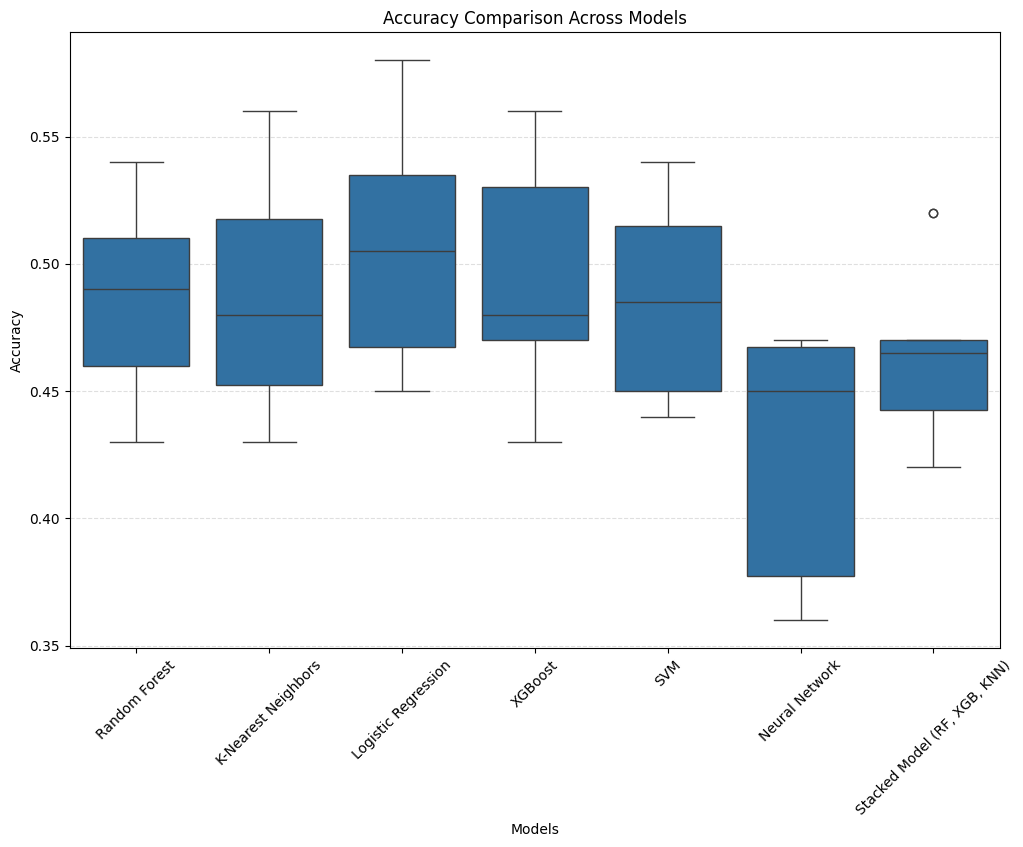

In [97]:
import seaborn as sns

plt.figure(figsize=(12, 8))
boxplot = sns.boxplot(data=df_accuracies, color='#2074b4')
plt.title('Accuracy Comparison Across Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
model_labels = [
    'Random Forest', 'K-Nearest Neighbors', 'Logistic Regression', 'XGBoost', 'SVM', 
    'Neural Network', 'Stacked Model (RF, XGB, KNN)'
]
boxplot.set_xticklabels(model_labels)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


In [95]:
df_accuracies_transposed = df_accuracies.T
df_accuracies_transposed 

,0,1,2,3,4,5,6,7,8,9
randomforestclassifier,0.46,0.46,0.50,0.46,0.43,0.54,0.51,0.54,0.48,0.51
kneighborsclassifier,0.45,0.45,0.49,0.47,0.43,0.56,0.52,0.53,0.51,0.46
logisticregression,0.46,0.51,0.52,0.50,0.46,0.58,0.54,0.56,0.49,0.45
xgbclassifier,0.47,0.43,0.53,0.48,0.46,0.53,0.54,0.56,0.48,0.47
svc,0.45,0.45,0.50,0.48,0.44,0.54,0.52,0.53,0.49,0.44
sequential,0.36,0.45,0.47,0.47,0.40,0.46,0.45,0.47,0.37,0.37
stackingclassifier,0.45,0.42,0.47,0.46,0.43,0.52,0.47,0.52,0.47,0.44


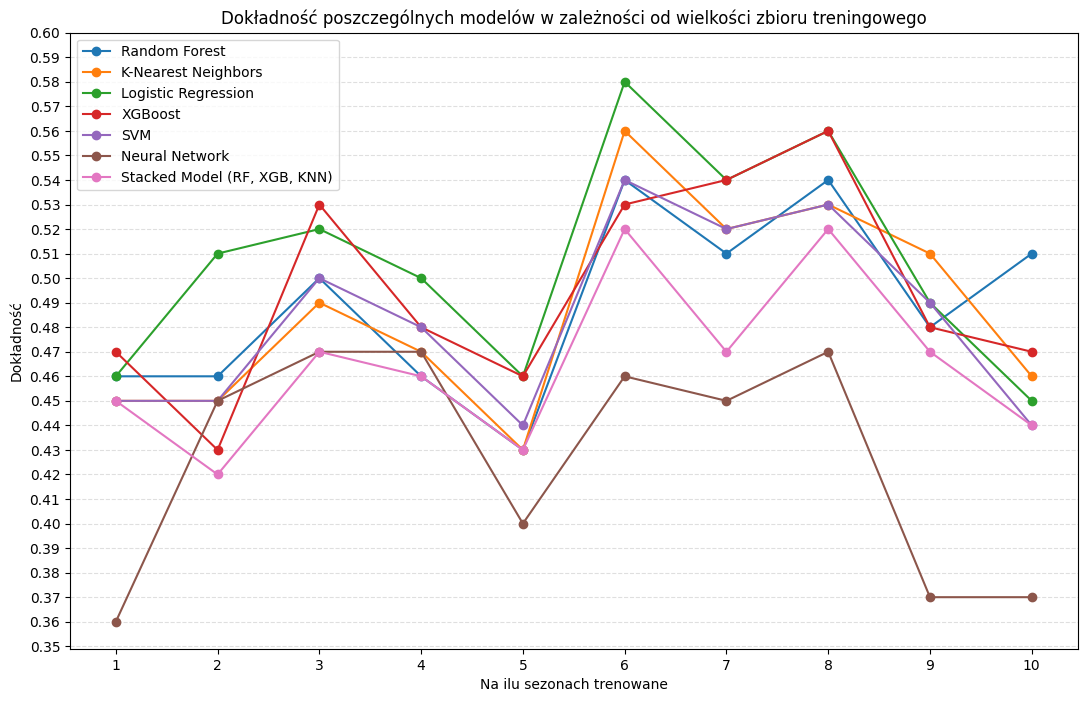

In [96]:
plt.figure(figsize=(13, 8))

for model, accuracies in df_accuracies_transposed.iterrows():
    plt.plot(df_accuracies.index + 1, accuracies, marker='o', label=model)

plt.title('Dokładność poszczególnych modelów w zależności od wielkości zbioru treningowego')
plt.xlabel('Na ilu sezonach trenowane')
plt.ylabel('Dokładność')
plt.xticks(df_accuracies.index + 1)
plt.yticks(np.arange(0.35, 0.61, 0.01))
plt.legend(model_labels)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()